In [1]:
# Data Wrangling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore

# Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Misc
import warnings # Supress warnings
import random
import itertools
from datetime import datetime, date

warnings.filterwarnings('ignore')
# plt.style.use('fivethirtyeight')
np.random.seed(7)

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:180%; text-align:center">TimeSeries 📈 ARIMA, Prophet, ADF, PACF... 📚 Beginner to Pro</p>

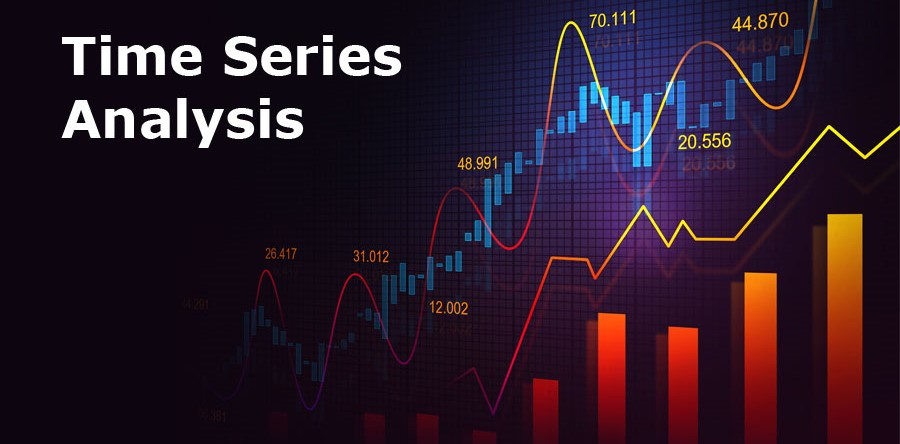

In this project I want to deep dive into TimeSeries analysis to show how to review the data, how to preview it and how to engineering.

I also want to explore some of the typical TimeSeries topics such as:
* ACF/PACF
* ARIMA
* Auto-ARIMA
* Prophet
* Augmented Dickey-Fuller (ADF)


## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">Table of Content</p>

* [1. Data visualization 📊](#1)
* [2. Data Preprocessing ⚙️](#2)
    * [2.1 Handle Missings](#2.1)
    * [2.2 Smoothing data / Resampling](#2.2)
    * [2.3 Stationarity](#2.3)
        * [2.3.1 Augmented Dickey-Fuller (ADF)](#2.3.1)
        * [2.3.2 Transforming](#2.3.2)
        * [2.3.3 Differencing](#2.3.3)
* [3. Feature engineering 🔧](#3)
    * [3.1 Encoding Cyclical Features](#3.1)
    * [3.2 TimeSeries Decomposition](#3.2)
    * [3.3 Lag](#3.3)
* [4. Exploratory Data Analysis 📊](#4)
    * [4.1 Autocorrelation Analysis](#4.1)
* [5. Modeling](#5)
    * [5.1 Models for Univariate Time Series](#5.1)
        * [5.1.1 Univariate Prophet](#5.1.1)
        * [5.1.2 ARIMA](#5.1.2)
        * [5.1.3 Auto-ARIMA](#5.1.3)
        * [5.1.4 LSTM](#5.1.4)
    * [5.2 Models for Multivariate Time Series](#5.2)
        * [5.1.1 Multivariate Prophet](#5.2.1)
* [6. Conclusions](#6)
* [7. References](#7)

In [2]:
df = pd.read_csv("retail-data.csv")

#Simplify column names
df.columns = ['date','sales','member','margin','quantity','cogs']

targets = ['sales']
features = [feature for feature in df.columns if feature not in targets]
df.head()

date         sales  member       margin  quantity          cogs
0  2018-05-01  1.842634e+09   18295  76273242.59   89801.0  1.766361e+09
1  2018-05-02  1.735156e+09   15927  71270127.97   82249.0  1.663886e+09
2  2018-05-03  1.614953e+09   14420  63691143.21   75508.0  1.551262e+09
3  2018-05-04  2.024222e+09   16053  81199681.84   85452.0  1.943022e+09
4  2018-05-05  2.354283e+09   18356  94021382.58   95683.0  2.260261e+09

In [3]:
df.shape

(1671, 6)

Since this is a TimeSeries problem, we have to parse 'date' column

In [4]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">1. Data visualization 📊</p>

Features:
* **Member** indicates total of indogrosir member merah
* **Margin** indicates margin of product sales
* **Quantity** indicates quantity of product sold (IDR)
* **COGS** indicates cost of good sold from product sales

Target:
* **Sales** indicates revenue of product sales (IDR)

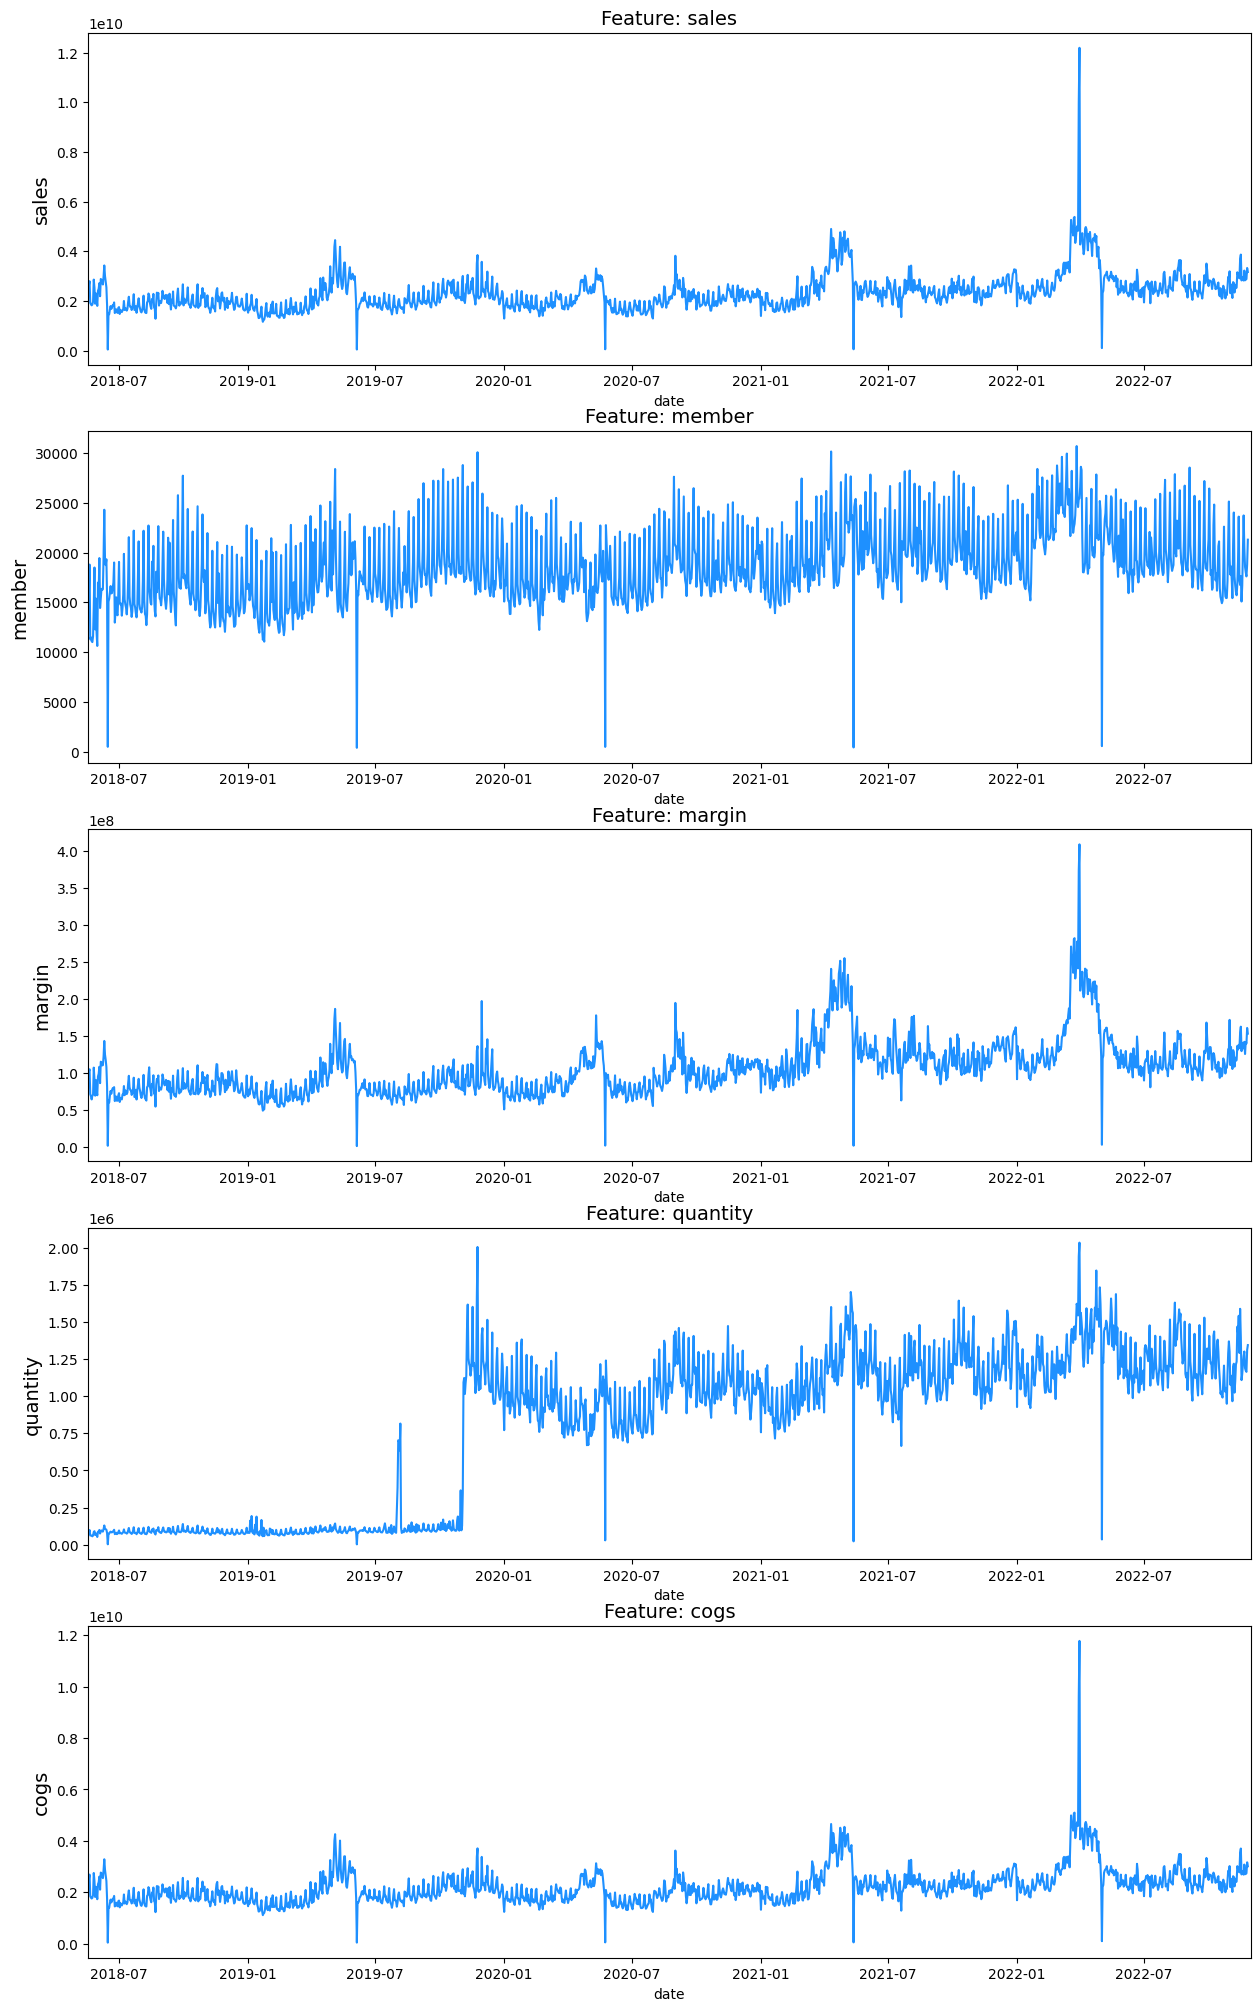

In [5]:
# To complete the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)              
    ax[i].set_xlim([date(2018, 5, 18), date(2022, 11, 30)])                

<a id='2'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">2. Data Preprocessing ⚙️</p>

## Chronological Order and Equidistant Timestamps

The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

But, first of all, lets see how to check if our dataset is correctly formated!

In [6]:
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

date  delta
0 2018-05-01    NaT
1 2018-05-02 1 days
2 2018-05-03 1 days
3 2018-05-04 1 days
4 2018-05-05 1 days

In [7]:
df['delta'].sum(), df['delta'].count()

(Timedelta('1670 days 00:00:00'), 1670)

This is already the case in our data: The time interval is one day and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.

<a id='2.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">2.1 Handle Missings</p>

As we can see, the dataset has some null values.

Furthermore, plotting the time series reveals that there seem to be **some zero values that seems to be nulls** for `features`. We will have to clean them by replacing them by nan values and filling them afterwards

In [8]:
df = df.drop('delta', axis=1)
df.isna().sum()

date        0
sales       0
member      0
margin      0
quantity    0
cogs        0
dtype: int64

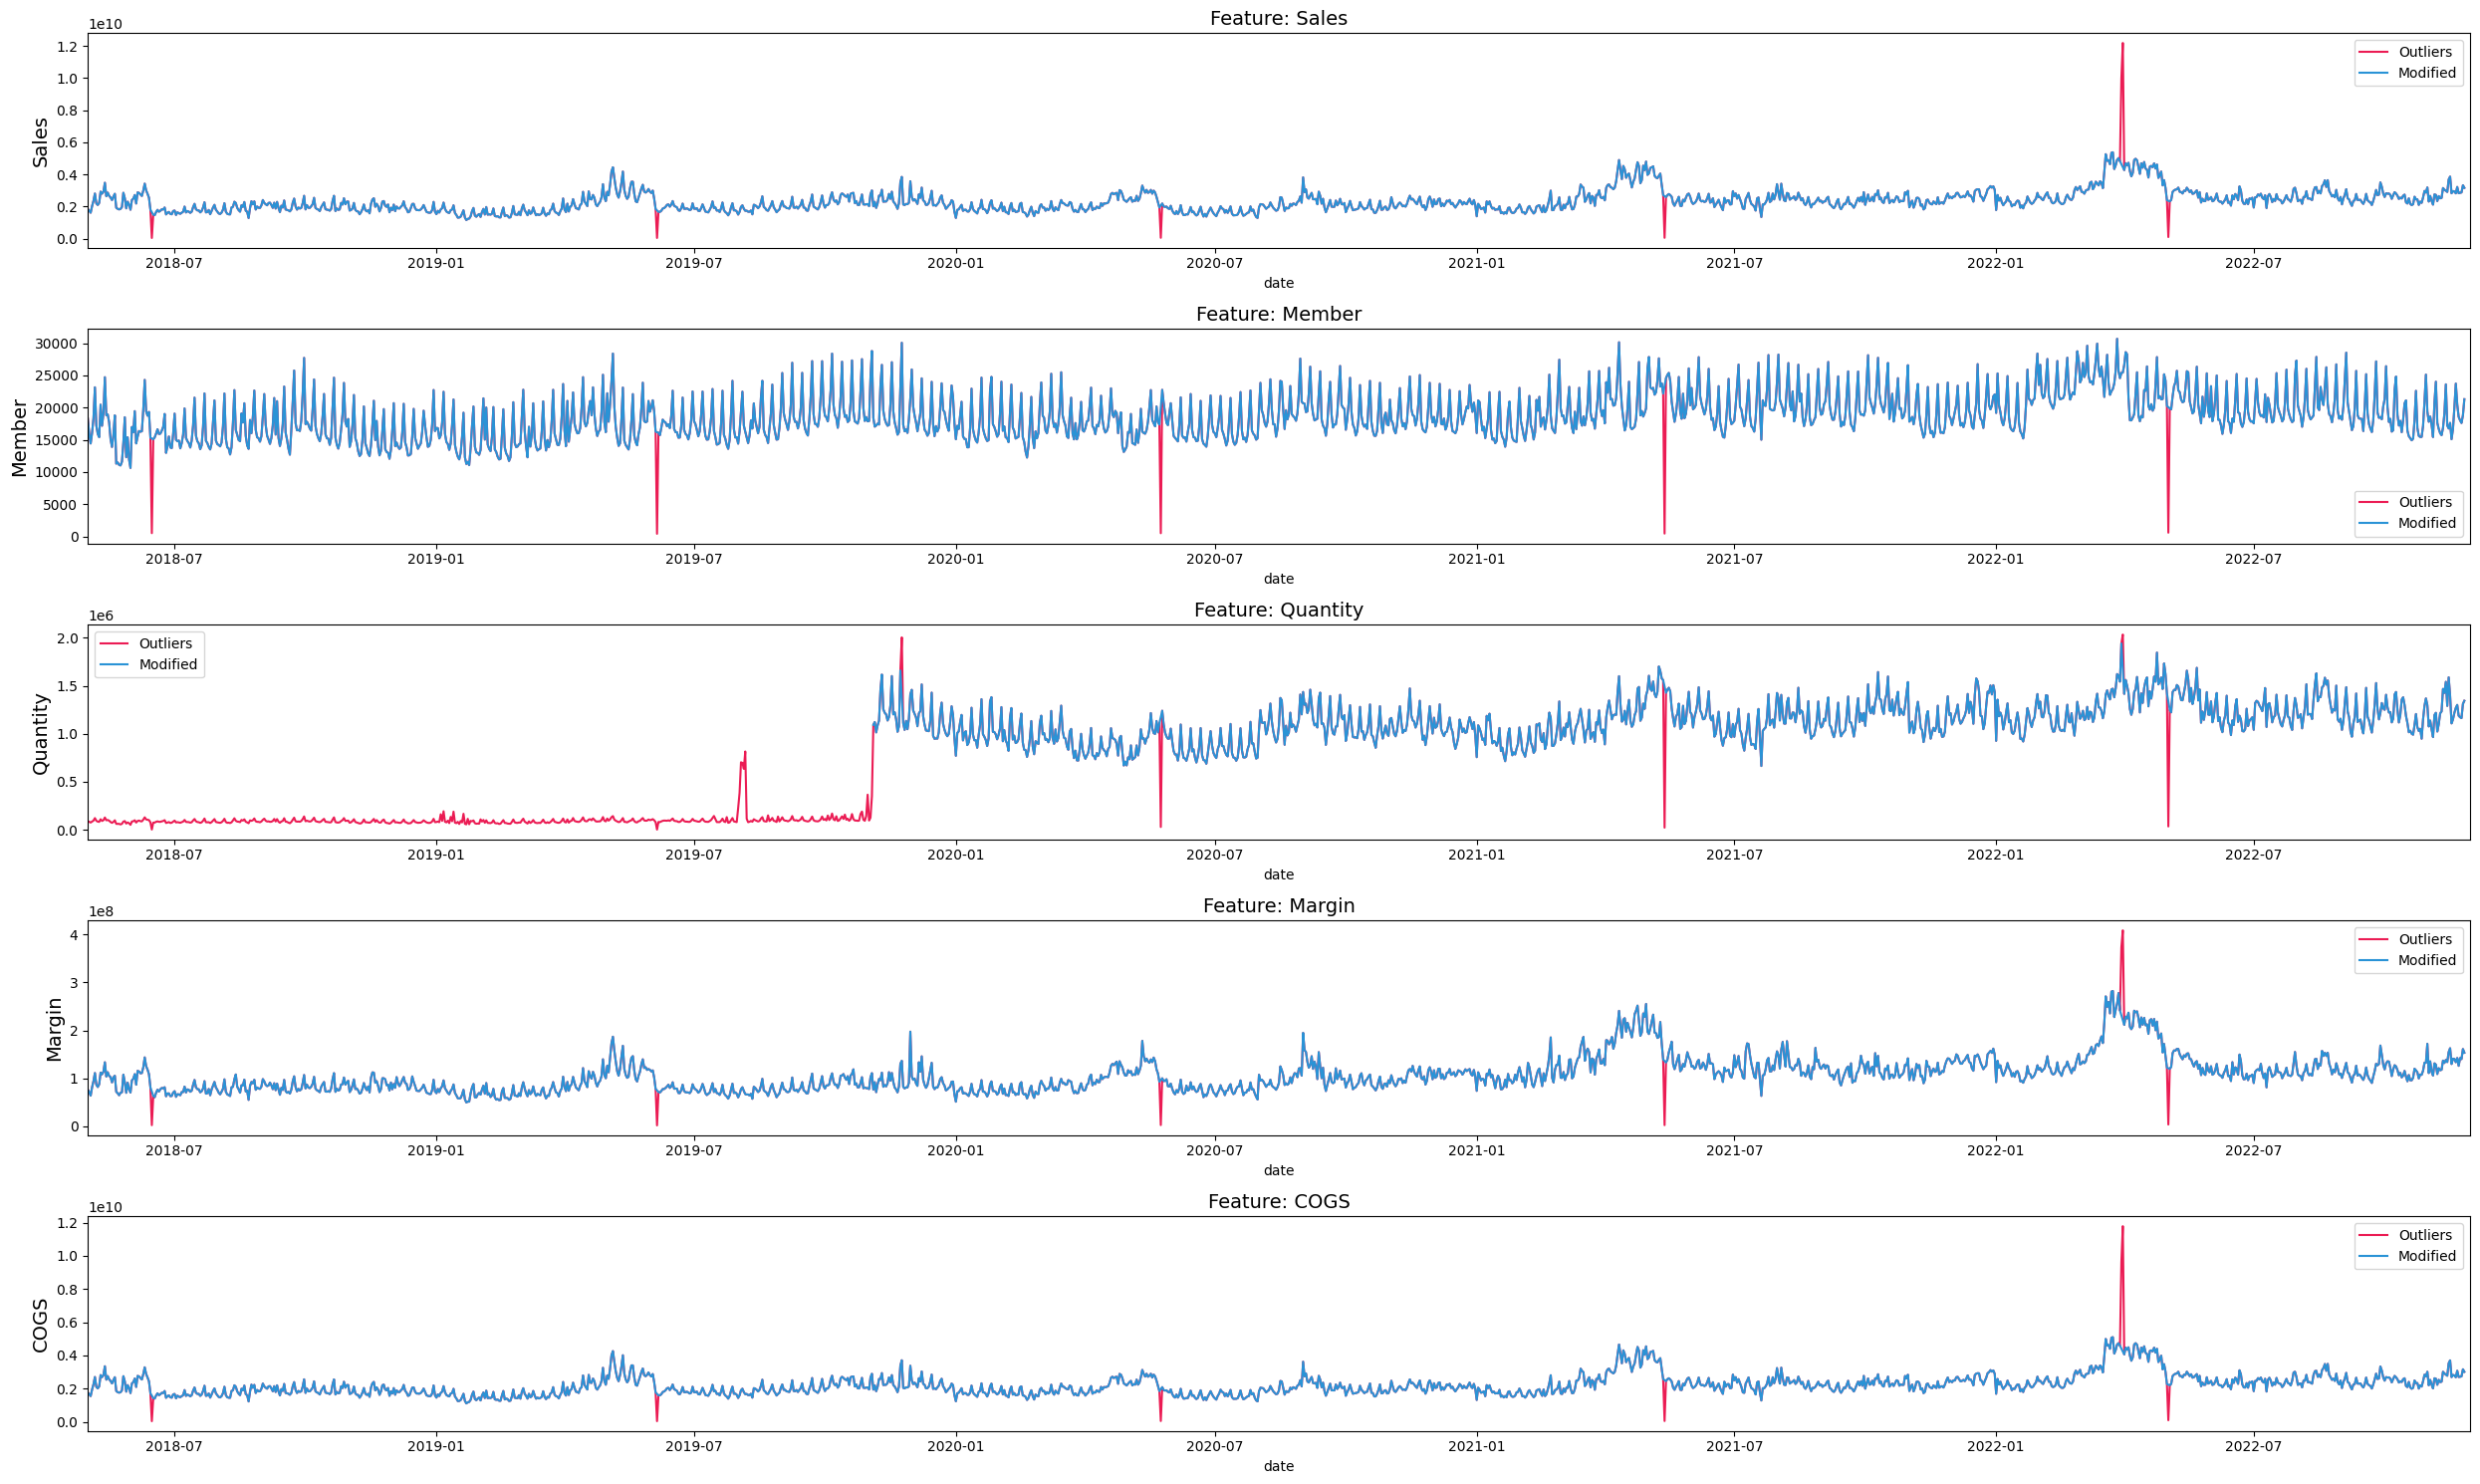

In [9]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(25, 15))


# Sales
old_sales = df['sales'].copy()
df['sales'] = df['sales'].replace(0, np.nan)
df.loc[df['date'] == '2018-06-15', 'sales'] = np.nan # Ramadhan
df.loc[df['date'] == '2019-06-05', 'sales'] = np.nan # Ramadhan
df.loc[df['date'] == '2020-05-24', 'sales'] = np.nan # Ramadhan
df.loc[df['date'] == '2021-05-13', 'sales'] = np.nan # Ramadhan
df.loc[df['date'] == '2022-03-30', 'sales'] = np.nan
df.loc[df['date'] == '2022-03-31', 'sales'] = np.nan
df.loc[df['date'] == '2022-05-02', 'sales'] = np.nan # Ramadhan

sns.lineplot(x=df['date'], y=old_sales, ax=ax[0], color='#EB1C54', label='Outliers')
sns.lineplot(x=df['date'], y=df['sales'].fillna(np.inf), ax=ax[0], color='#2A93D6', label='Modified')
ax[0].set_title('Feature: Sales', fontsize=14)
ax[0].set_ylabel(ylabel='Sales', fontsize=14)
ax[0].set_xlim([date(2018, 5, 1), date(2022, 11, 30)])

# Member
old_member = df['member'].copy()
df['member'] = df['member'].replace(0, np.nan)
df.loc[df['date'] == '2018-06-15', 'member'] = np.nan # Ramadhan
df.loc[df['date'] == '2019-06-05', 'member'] = np.nan # Ramadhan
df.loc[df['date'] == '2020-05-24', 'member'] = np.nan # Ramadhan
df.loc[df['date'] == '2021-05-13', 'member'] = np.nan # Ramadhan
df.loc[df['date'] == '2022-05-02', 'member'] = np.nan # Ramadhan

sns.lineplot(x=df['date'], y=old_member, ax=ax[1], color='#EB1C54', label='Outliers')
sns.lineplot(x=df['date'], y=df['member'].fillna(np.inf), ax=ax[1], color='#2A93D6', label='Modified')
ax[1].set_title('Feature: Member', fontsize=14)
ax[1].set_ylabel(ylabel='Member', fontsize=14)
ax[1].set_xlim([date(2018, 5, 1), date(2022, 11, 30)])

# Quantity
old_member = df['quantity'].copy()
df['quantity'] = df['quantity'].replace(0, np.nan)
df.loc[0:551, 'quantity'] = np.nan # Anomaly
df.loc[df['date'] == '2022-03-31', 'quantity'] = np.nan
df.loc[df['date'] == '2019-11-24', 'quantity'] = np.nan
df.loc[df['date'] == '2018-06-15', 'quantity'] = np.nan # Ramadhan
df.loc[df['date'] == '2019-06-05', 'quantity'] = np.nan # Ramadhan
df.loc[df['date'] == '2020-05-24', 'quantity'] = np.nan # Ramadhan
df.loc[df['date'] == '2021-05-13', 'quantity'] = np.nan # Ramadhan
df.loc[df['date'] == '2022-05-02', 'quantity'] = np.nan # Ramadhan

sns.lineplot(x=df['date'], y=old_member, ax=ax[2], color='#EB1C54', label='Outliers')
sns.lineplot(x=df['date'], y=df['quantity'].fillna(np.inf), ax=ax[2], color='#2A93D6', label='Modified')
ax[2].set_title('Feature: Quantity', fontsize=14)
ax[2].set_ylabel(ylabel='Quantity', fontsize=14)
ax[2].set_xlim([date(2018, 5, 1), date(2022, 11, 30)])

# Margin
old_margin = df['margin'].copy()
df['margin'] = df['margin'].replace(0, np.nan)
df.loc[df['date'] == '2018-06-15', 'margin'] = np.nan # Ramadhan
df.loc[df['date'] == '2019-06-05', 'margin'] = np.nan # Ramadhan
df.loc[df['date'] == '2020-05-24', 'margin'] = np.nan # Ramadhan
df.loc[df['date'] == '2021-05-13', 'margin'] = np.nan # Ramadhan
df.loc[df['date'] == '2022-03-30', 'margin'] = np.nan
df.loc[df['date'] == '2022-03-31', 'margin'] = np.nan
df.loc[df['date'] == '2022-05-02', 'margin'] = np.nan # Ramadhan

sns.lineplot(x=df['date'], y=old_margin, ax=ax[3], color='#EB1C54', label='Outliers')
sns.lineplot(x=df['date'], y=df['margin'].fillna(np.inf), ax=ax[3], color='#2A93D6', label='Modified')
ax[3].set_title('Feature: Margin', fontsize=14)
ax[3].set_ylabel(ylabel='Margin', fontsize=14)
ax[3].set_xlim([date(2018, 5, 1), date(2022, 11, 30)])

# COGS
old_cogs = df['cogs'].copy()
df['cogs'] = df['cogs'].replace(0, np.nan)
df.loc[df['date'] == '2018-06-15', 'cogs'] = np.nan # Ramadhan
df.loc[df['date'] == '2019-06-05', 'cogs'] = np.nan # Ramadhan
df.loc[df['date'] == '2020-05-24', 'cogs'] = np.nan # Ramadhan
df.loc[df['date'] == '2021-05-13', 'cogs'] = np.nan # Ramadhan
df.loc[df['date'] == '2022-03-30', 'cogs'] = np.nan
df.loc[df['date'] == '2022-03-31', 'cogs'] = np.nan
df.loc[df['date'] == '2022-05-02', 'cogs'] = np.nan # Ramadhan

sns.lineplot(x=df['date'], y=old_cogs, ax=ax[4], color='#EB1C54', label='Outliers')
sns.lineplot(x=df['date'], y=df['cogs'].fillna(np.inf), ax=ax[4], color='#2A93D6', label='Modified')
ax[4].set_title('Feature: COGS', fontsize=14)
ax[4].set_ylabel(ylabel='COGS', fontsize=14)
ax[4].set_xlim([date(2018, 5, 1), date(2022, 11, 30)])

plt.tight_layout()
plt.show()

So now we have to fix missing values. Lets take a look of these cases and explore what can we do with them.

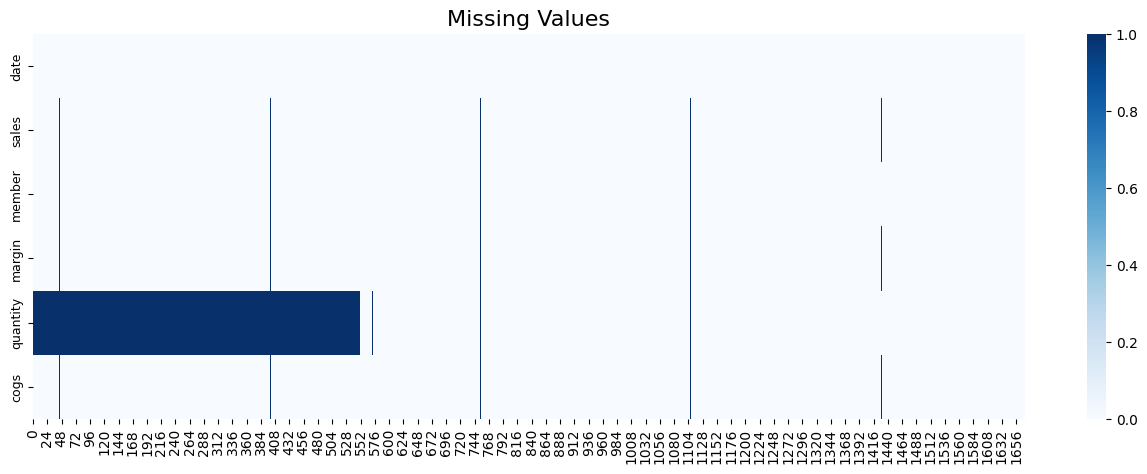

In [10]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(9)
plt.show()

### Missing Values, how to handle

* **Option 1: Fill NaN with Outlier or Zero**

In this specific example filling the missing value with an outlier value such as np.inf or 0 seems to be very naive. However, using values like -999, is sometimes a good idea.

* **Option 2: Fill NaN with Mean Value**

Filling NaNs with the mean value is also not sufficient and naive, and doesn't seems to be a good option.

* **Option 3: Fill NaN with Last Value with .ffill()**

Filling NaNs with the last value could be bit better.

* **Option 4: Fill NaN with Linearly Interpolated Value with .interpolate()**

Filling NaNs with the interpolated values is the best option in this small example but it requires knowledge of the neighbouring value

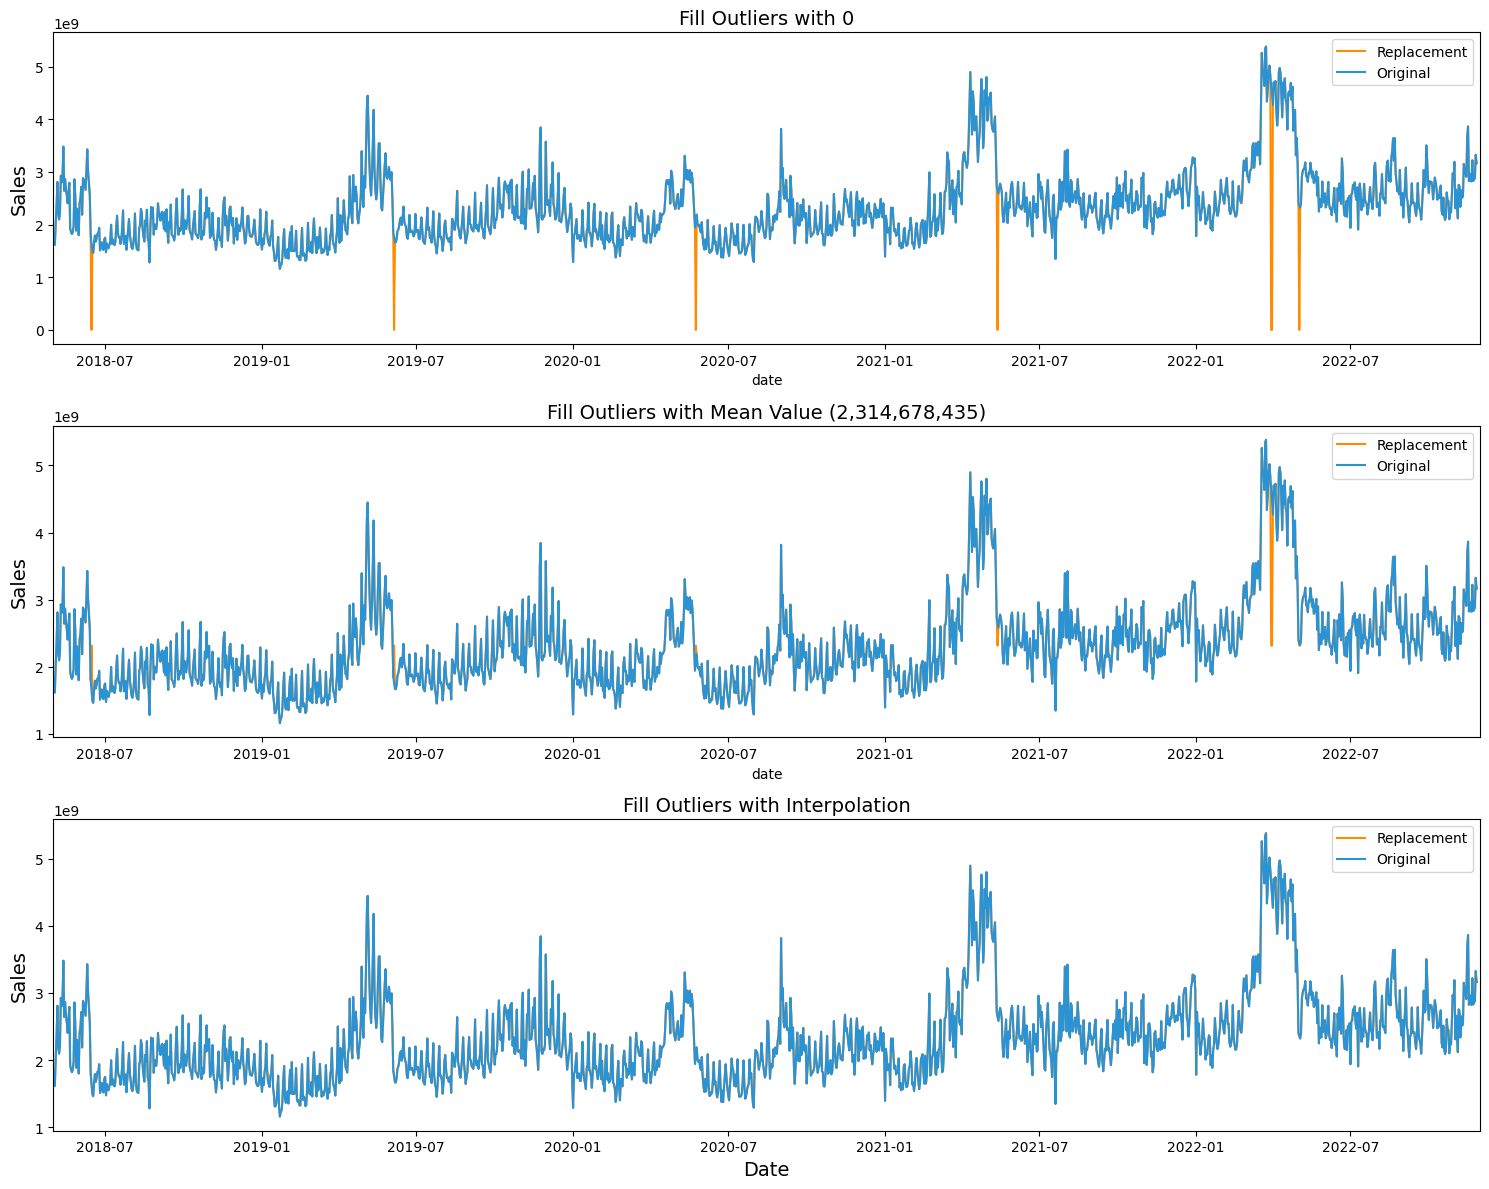

In [11]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['sales'].fillna(0), ax=ax[0], color='darkorange', label = 'Replacement')
sns.lineplot(x=df['date'], y=df['sales'].fillna(np.inf), ax=ax[0], color='#2A93D6', label = 'Original')
ax[0].set_title('Fill Outliers with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Sales', fontsize=14)

mean_drainage = df['sales'].mean()
sns.lineplot(x=df['date'], y=df['sales'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'Replacement')
sns.lineplot(x=df['date'], y=df['sales'].fillna(np.inf), ax=ax[1], color='#2A93D6', label = 'Original')
ax[1].set_title(f'Fill Outliers with Mean Value ({mean_drainage:,.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Sales', fontsize=14)

# sns.lineplot(x=df['date'], y=df['sales'].ffill(), ax=ax[2], color='darkorange', label = 'Replacement')
# sns.lineplot(x=df['date'], y=df['sales'].fillna(np.inf), ax=ax[2], color='#2A93D6', label = 'Original')
# ax[2].set_title(f'Fill Outliers with Previous Value', fontsize=14)
# ax[2].set_ylabel(ylabel='Sales', fontsize=14)
# ax[2].set_xlabel(xlabel='Date', fontsize=14)

sns.lineplot(x=df['date'], y=df['sales'].interpolate(), ax=ax[2], color='darkorange', label = 'Replacement')
sns.lineplot(x=df['date'], y=df['sales'].fillna(np.inf), ax=ax[2], color='#2A93D6', label = 'Original')
ax[2].set_title(f'Fill Outliers with Interpolation', fontsize=14)
ax[2].set_ylabel(ylabel='Sales', fontsize=14)
ax[2].set_xlabel(xlabel='Date', fontsize=14)

for i in range(3):
    ax[i].set_xlim([date(2018, 5, 1), date(2022, 11, 30)])
    
plt.tight_layout()
plt.show()

As we can see, the best option in this case, **seems to best option!**

So, lets interpolate missing values

In [12]:
df['sales'] = df['sales'].interpolate()
df['member'] = df['member'].interpolate()
df['quantity'] = df['quantity'].fillna(df['quantity'].mean())
df['margin'] = df['margin'].interpolate()
df['cogs'] = df['cogs'].interpolate()

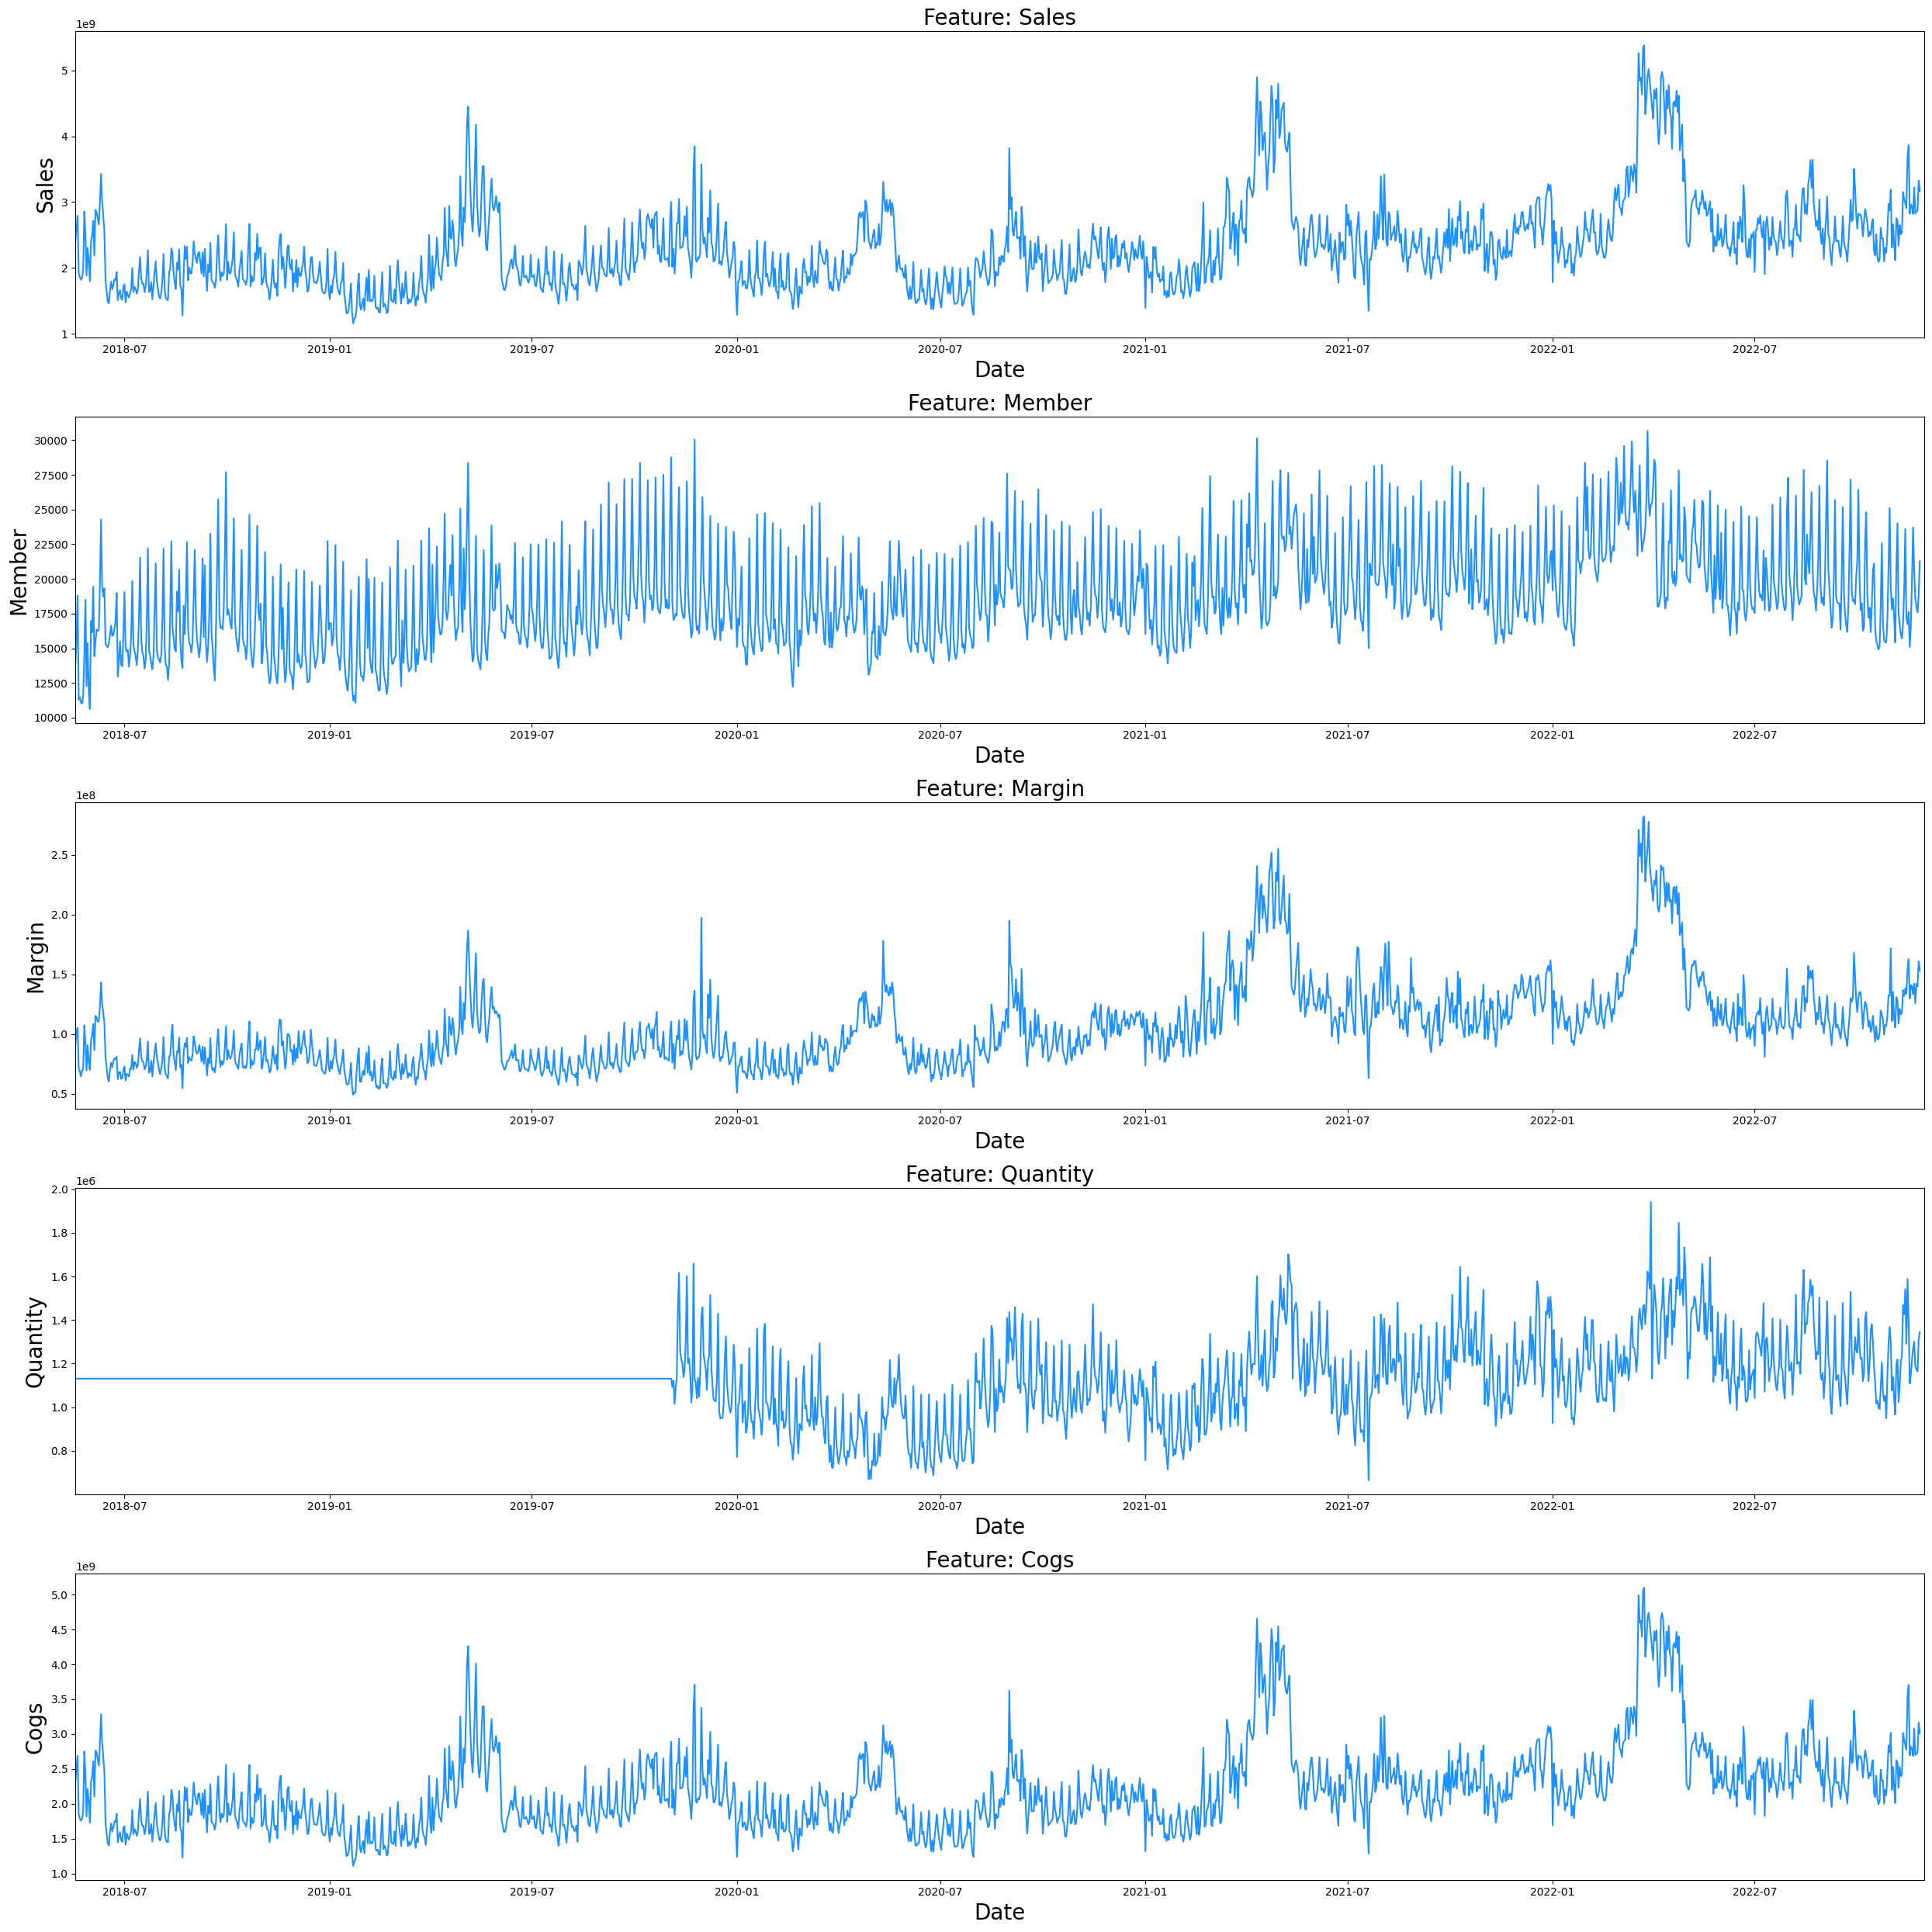

In [13]:
# To complete the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(25, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column.capitalize()), fontsize=20)
    ax[i].set_ylabel(ylabel=column.capitalize(), fontsize=20)
    ax[i].set_xlabel(xlabel='Date', fontsize=20)              
    ax[i].set_xlim([date(2018, 5, 18), date(2022, 11, 30)])

plt.tight_layout()
plt.show()                

In [14]:
df.isna().sum()

date        0
sales       0
member      0
margin      0
quantity    0
cogs        0
dtype: int64

<a id='2.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">2.2 Smoothing data / Resampling</p>

Resampling can provide additional information on the data. There are two types of resampling:

* **Upsampling** is when the frequency of samples is increased (e.g. days to hours)
* **Downsampling** is when the frequency of samples is decreased (e.g. days to weeks)

In this example, we will do some downsampling with the .resample() function (similar to groupby and aggregate as mean).

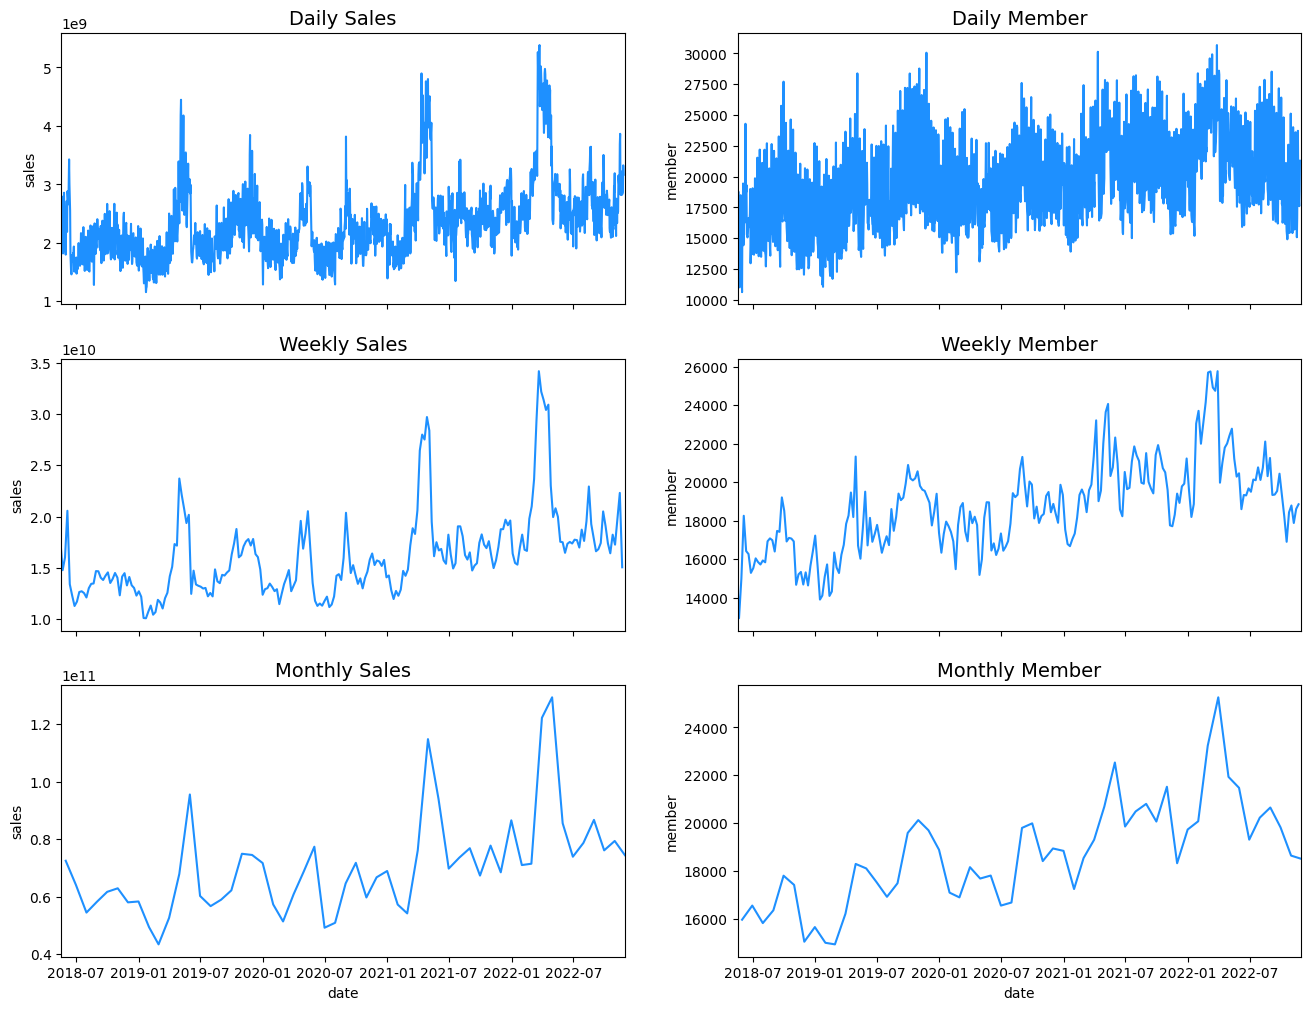

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))

sns.lineplot(x=df['date'], y=df['sales'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Daily Sales', fontsize=14)

resampled_df = df[['date','sales']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'],y=resampled_df['sales'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Sales', fontsize=14)

resampled_df = df[['date','sales']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['sales'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Sales', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2018, 5, 18), date(2022, 11, 30)])

sns.lineplot(x=df['date'], y=df['member'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Member', fontsize=14)

resampled_df = df[['date','member']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'],y=resampled_df['member'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Member', fontsize=14)

resampled_df = df[['date','member']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['date'], y=resampled_df['member'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Member', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim([date(2018, 5, 18), date(2022, 11, 30)])
plt.show()

<a id='2.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">2.3 Stationarity</p>

Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has

* constant mean and mean is not time-dependent
* constant variance and variance is not time-dependent
* constant covariance and covariance is not time-dependent

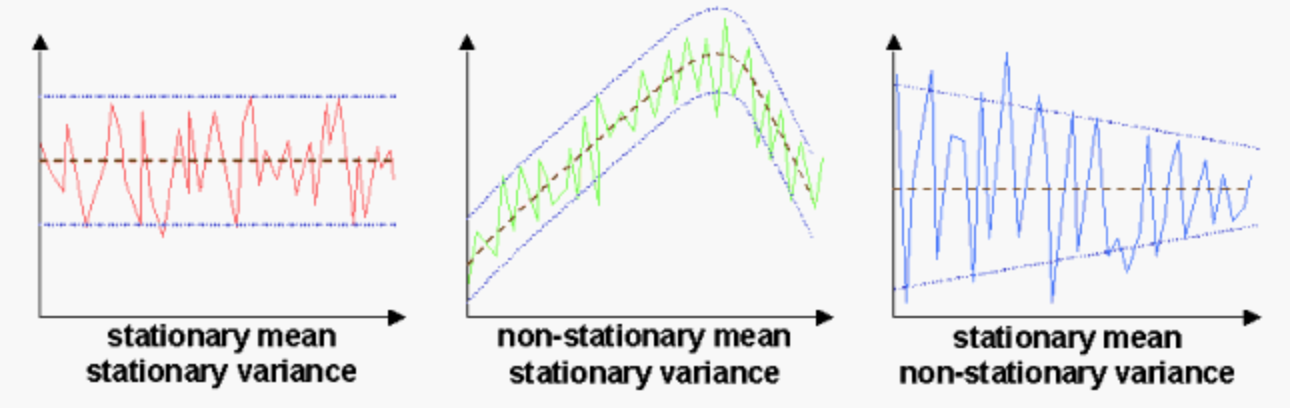

The check for stationarity can be done via three different approaches:

1. **visually**: plot time series and check for trends or seasonality
2. **basic statistics**: split time series and compare the mean and variance of each partition
3. **statistical test**: Augmented Dickey Fuller test

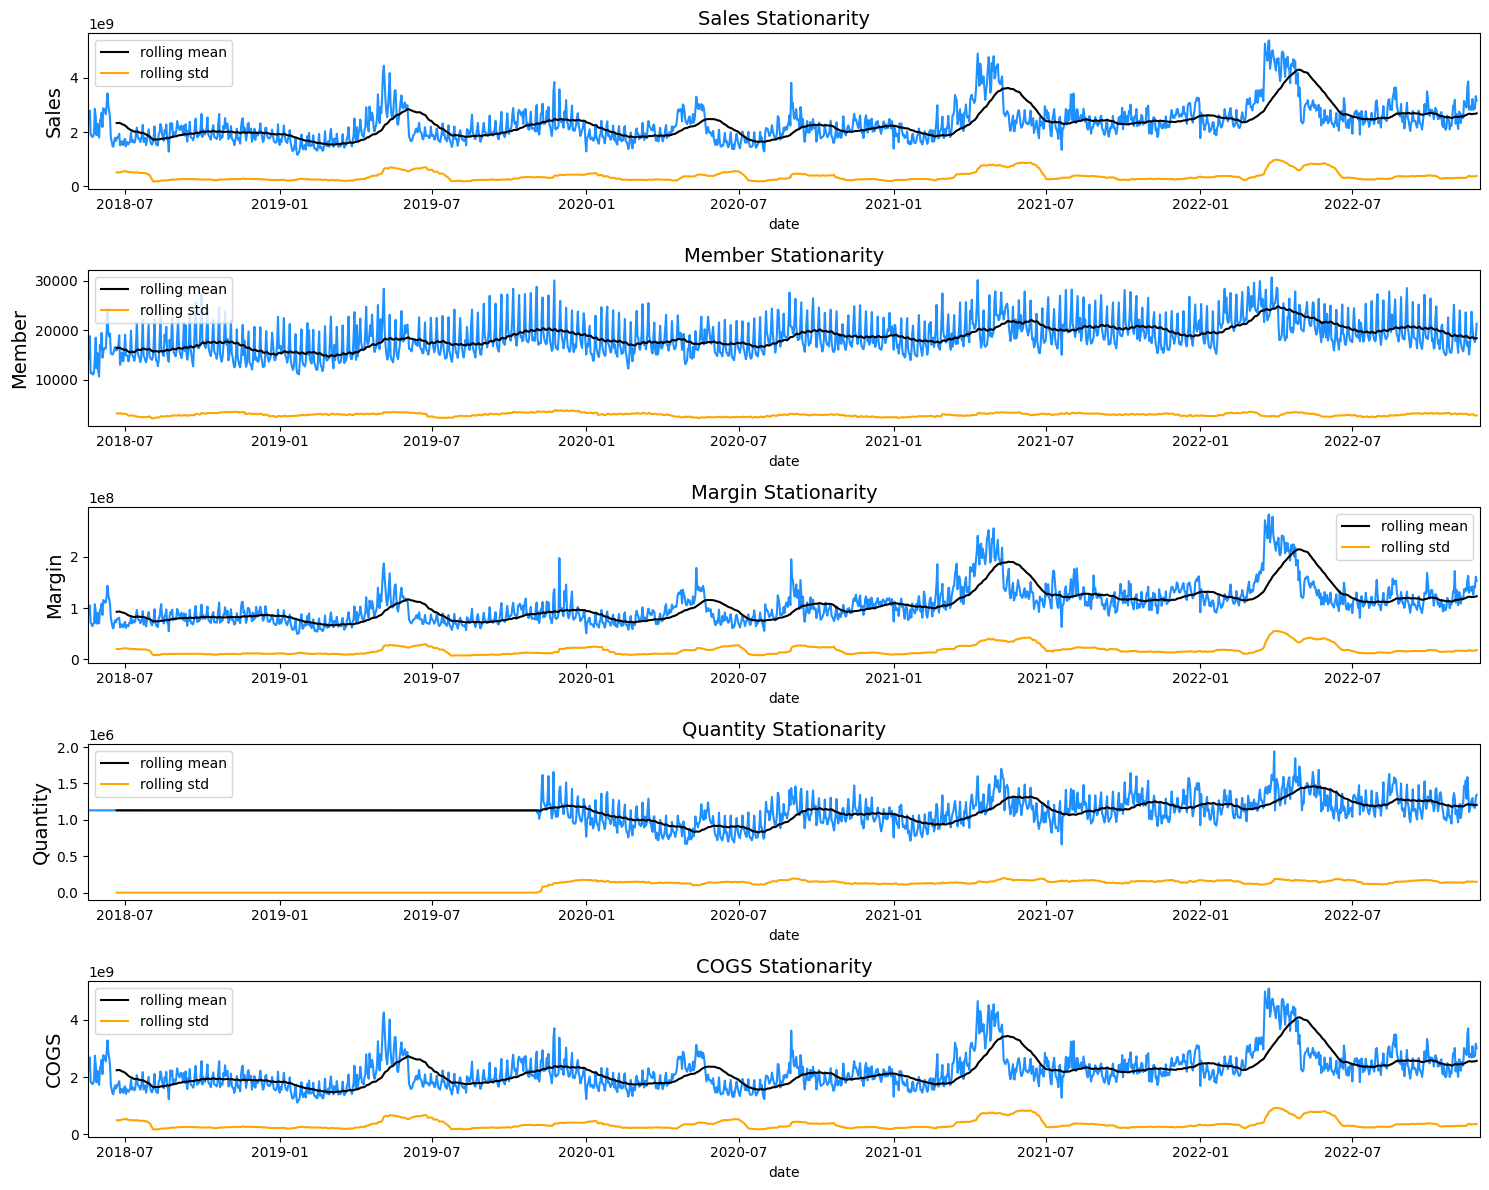

In [16]:
# A year has 52 weeks (52 weeks * 7 days per week) aporx.
rolling_window = 52
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['sales'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['sales'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['sales'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Sales Stationarity', fontsize=14)
ax[0].set_ylabel(ylabel='Sales', fontsize=14)
ax[0].set_xlim([date(2018, 5, 18), date(2022, 11, 30)])

sns.lineplot(x=df['date'], y=df['member'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['member'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['member'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Member Stationarity', fontsize=14)
ax[1].set_ylabel(ylabel='Member', fontsize=14)
ax[1].set_xlim([date(2018, 5, 18), date(2022, 11, 30)])

sns.lineplot(x=df['date'], y=df['margin'], ax=ax[2], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['margin'].rolling(rolling_window).mean(), ax=ax[2], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['margin'].rolling(rolling_window).std(), ax=ax[2], color='orange', label='rolling std')
ax[2].set_title('Margin Stationarity', fontsize=14)
ax[2].set_ylabel(ylabel='Margin', fontsize=14)
ax[2].set_xlim([date(2018, 5, 18), date(2022, 11, 30)])

sns.lineplot(x=df['date'], y=df['quantity'], ax=ax[3], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['quantity'].rolling(rolling_window).mean(), ax=ax[3], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['quantity'].rolling(rolling_window).std(), ax=ax[3], color='orange', label='rolling std')
ax[3].set_title('Quantity Stationarity', fontsize=14)
ax[3].set_ylabel(ylabel='Quantity', fontsize=14)
ax[3].set_xlim([date(2018, 5, 18), date(2022, 11, 30)])

sns.lineplot(x=df['date'], y=df['cogs'], ax=ax[4], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['cogs'].rolling(rolling_window).mean(), ax=ax[4], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['cogs'].rolling(rolling_window).std(), ax=ax[4], color='orange', label='rolling std')
ax[4].set_title('COGS Stationarity', fontsize=14)
ax[4].set_ylabel(ylabel='COGS', fontsize=14)
ax[4].set_xlim([date(2018, 5, 18), date(2022, 11, 30)])

plt.tight_layout()
plt.show()

In this **visual check**, we can see that the **features don't have constant mean and std**, but they are close to it.

<a id='2.3.1'></a>
### Unit Root Test

Unit root is a characteristic of a time series that makes it non-stationary. And ADF test belong to the unit root test. Technically , a unit root is said to exist in a time series of value of alpha =1 in below equation.

$Y_t = 	\alpha Y_{t-1} + 	\beta X_{e} + \epsilon $

where Yt is value of the time series at time ‘t’ and Xe is an exogenous variable .

**The presence of a unit root means the time series is non-stationary.**

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">2.3.1 Augmented Dickey-Fuller (ADF)</p>


**Augmented Dickey-Fuller (ADF)** test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

* **Null Hypothesis (H0)**: Time series has a unit root. (Time series is not stationary).

* **Alternate Hypothesis (H1)**: Time series has no unit root (Time series is stationary).

**If the null hypothesis can be rejected, we can conclude that the time series is stationary.**

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

* <font color='red'>**p-value > significance level (default: 0.05)**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**p-value <= significance level (default: 0.05)**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.
    
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.
* <font color='red'>**ADF statistic > critical value**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**ADF statistic < critical value**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.

In [17]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['sales'].values)
result

(-3.611717048619173,
 0.005540933710413051,
 21,
 1649,
 {'1%': -3.4343218063763605,
  '5%': -2.863294325252669,
  '10%': -2.567703962071947},
 68401.64925818866)

Now, we are going to check for each variable:
* The p-value is less than 0.05
* Check the range of the ADF statistic compared with critical_values 

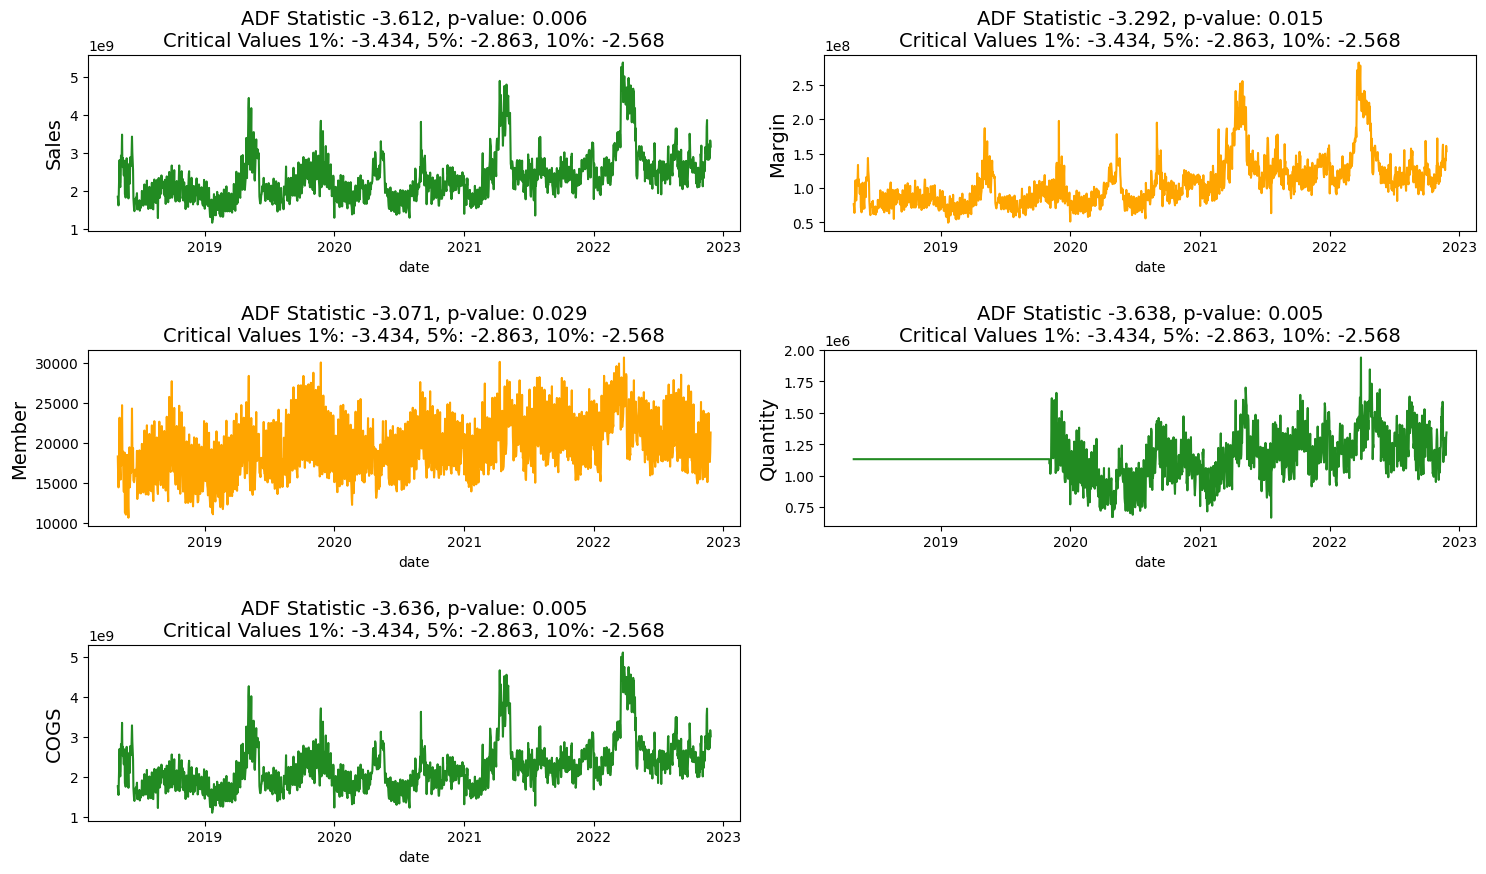

In [18]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['sales'].values, 'Sales', ax[0, 0])
visualize_adfuller_results(df['member'].values, 'Member', ax[1, 0])
visualize_adfuller_results(df['margin'].values, 'Margin', ax[0, 1])
visualize_adfuller_results(df['quantity'].values, 'Quantity', ax[1, 1])
visualize_adfuller_results(df['cogs'].values, 'COGS', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

If the data is not stationary but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed.

The two most common methods to transform series into stationarity ones are:

* **Transformation**: e.g. log or square root to stabilize non-constant variance
* **Differencing**: subtracts the current value from the previous

<a id='2.3.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">2.3.2 Transforming</p>

<Axes: xlabel='sales_log', ylabel='Density'>

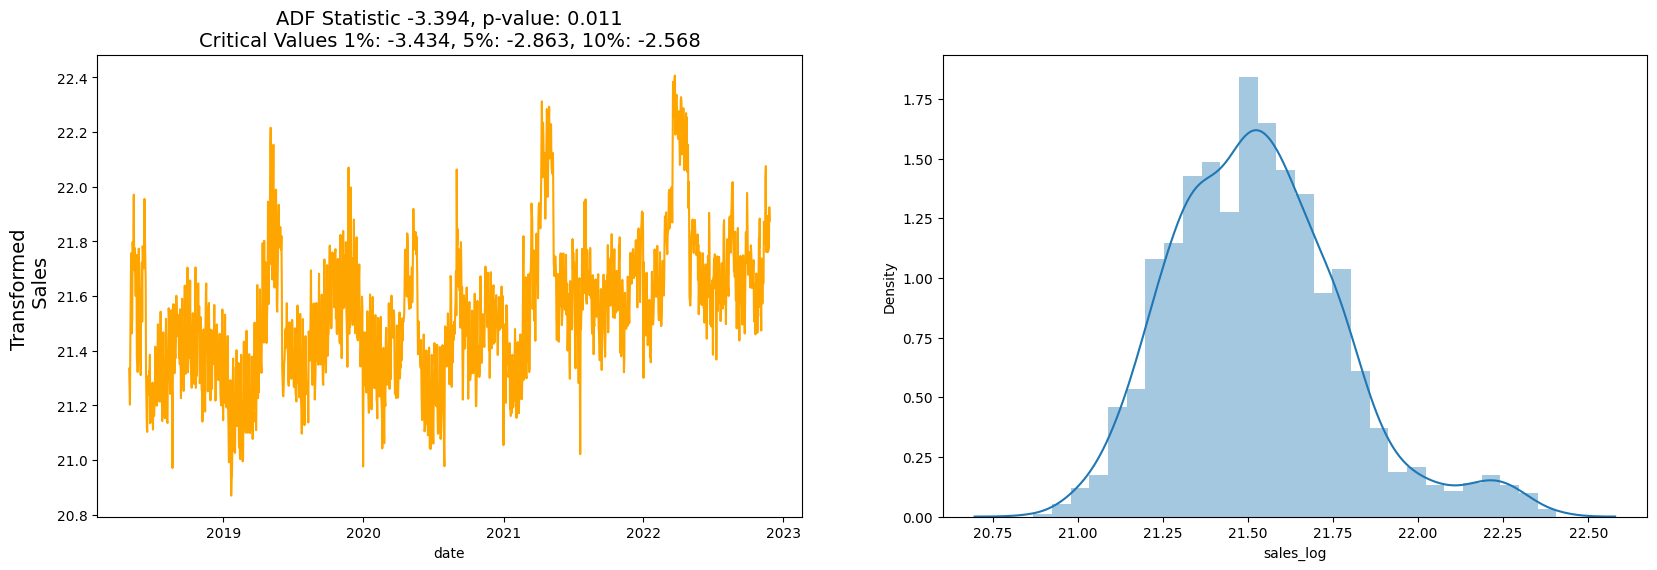

In [19]:
# Log Transform of absolute values
# (Log transform of negative values will return NaN)
df['sales_log'] = np.log(abs(df['sales']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['sales_log'], 'Transformed \n Sales', ax[0])

sns.distplot(df['sales_log'], ax=ax[1])

Differencing can be done in different orders:
* First order differencing: linear trends with $z_i = y_i - y_{i-1}$
* Second-order differencing: quadratic trends with $z_i = (y_i - y_{i-1}) - (y_{i-1} - y_{i-2})$
* and so on...

<a id='2.3.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">2.3.3 Differencing</p>

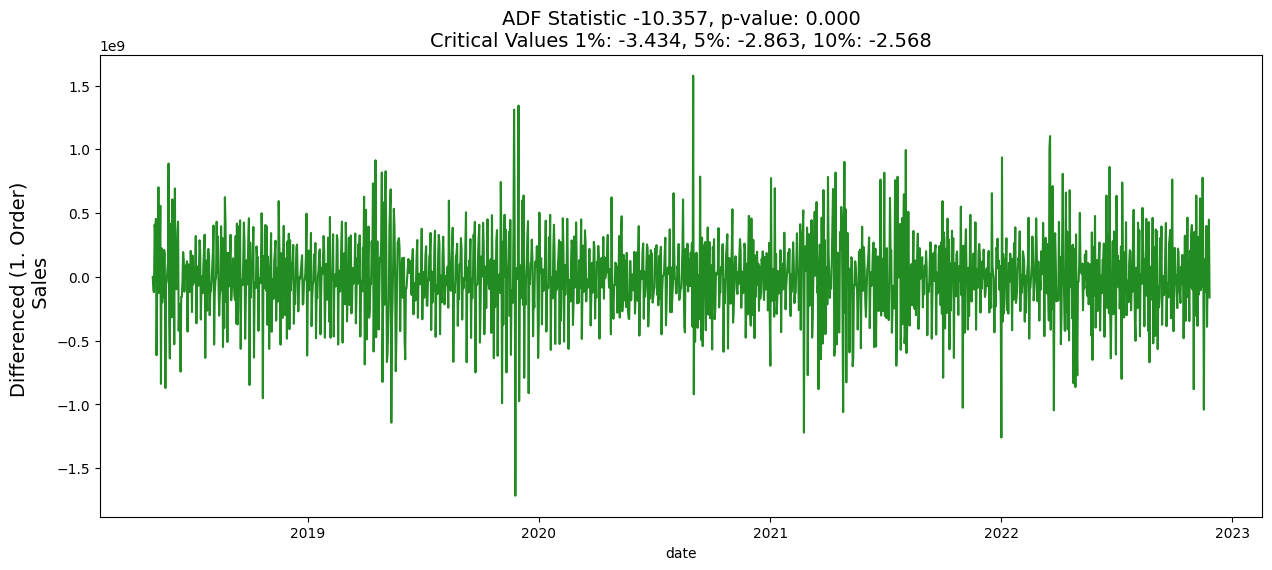

In [20]:
# First Order Differencing
ts_diff = np.diff(df['sales'])
df['sales_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['sales_diff_1'], 'Differenced (1. Order) \n Sales', ax)

<a id='3'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">3. Feature engineering 🔧</p>

In [21]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

date  year  month  day  day_of_year  week_of_year  quarter  season
0 2018-05-01  2018      5    1          121            18        2       2
1 2018-05-02  2018      5    2          122            18        2       2
2 2018-05-03  2018      5    3          123            18        2       2
3 2018-05-04  2018      5    4          124            18        2       2
4 2018-05-05  2018      5    5          125            18        2       2

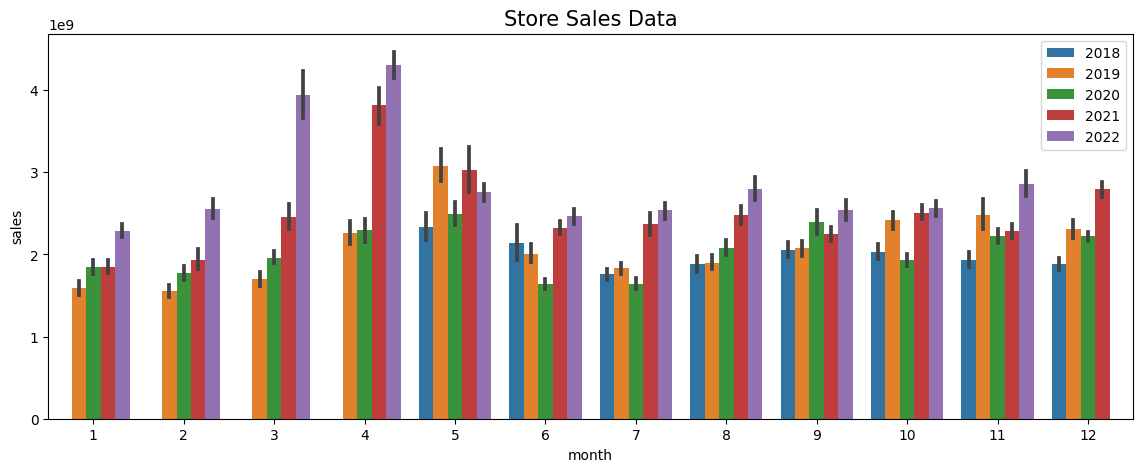

In [22]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="sales",hue='year',data=df)
a.set_title("Store Sales Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

Text(0.5, 1.0, 'Total Sales Received By year')

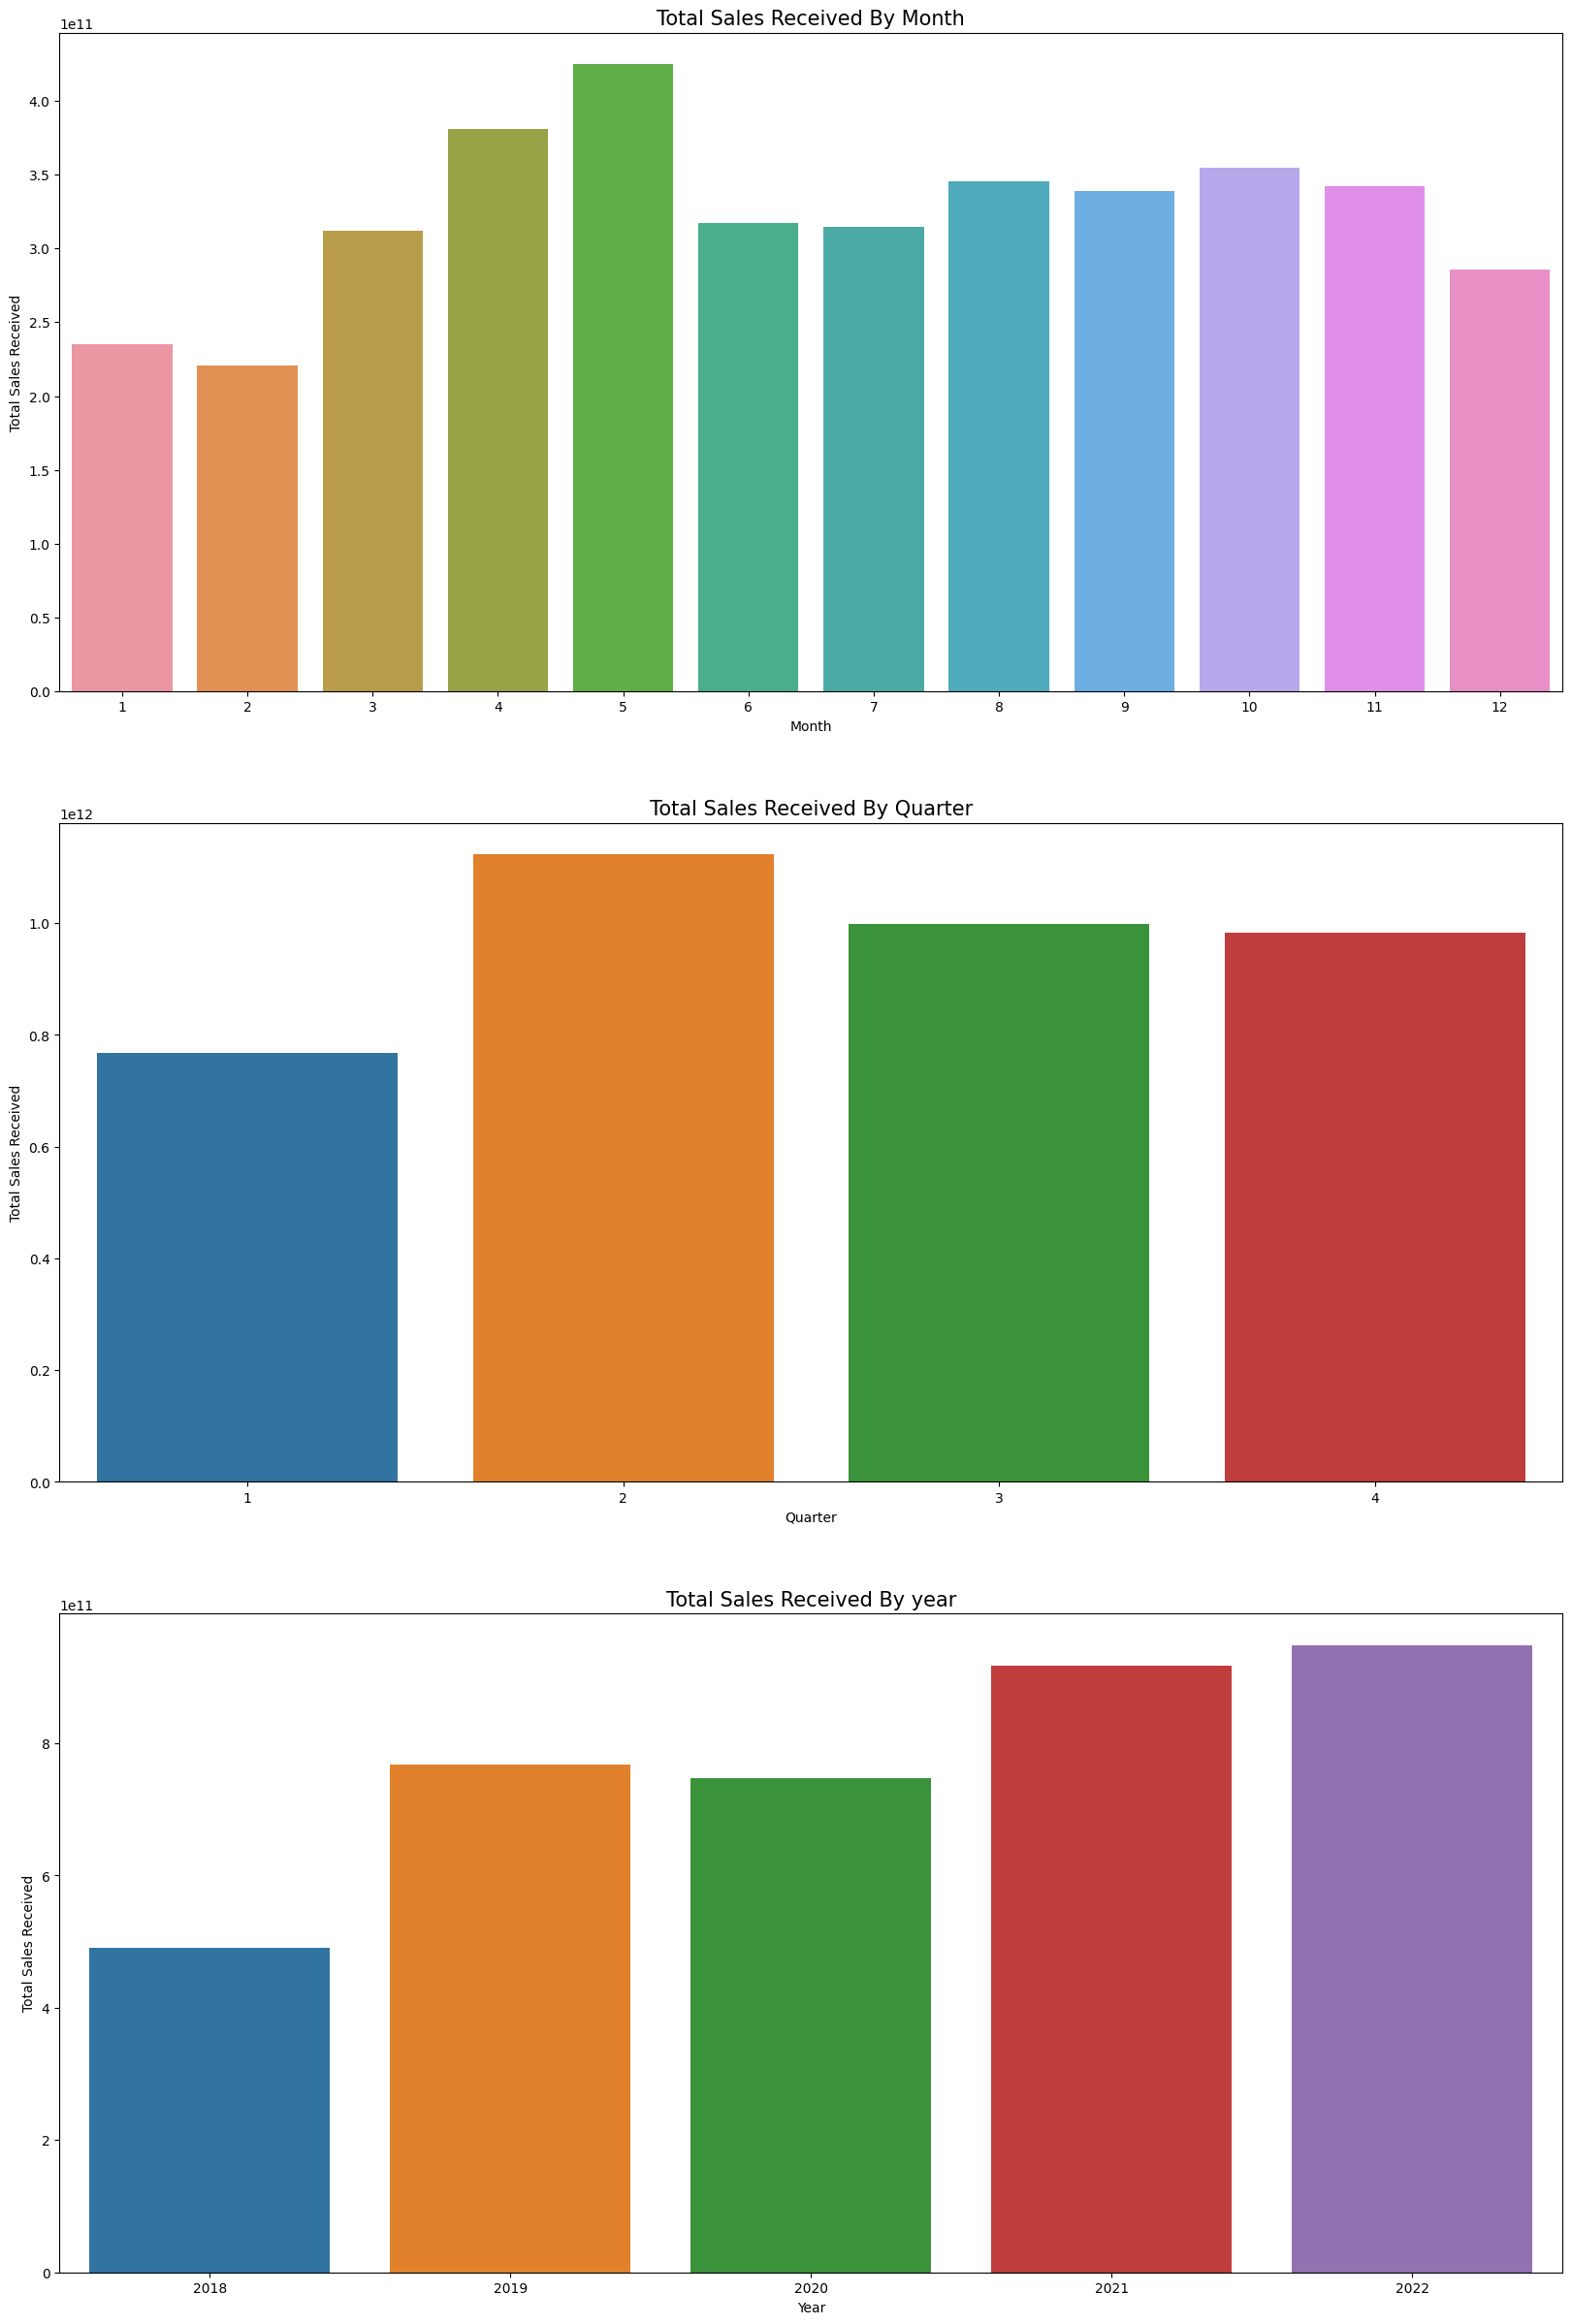

In [23]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(20,30)

monthAggregated = pd.DataFrame(df.groupby("month")["sales"].sum()).reset_index().sort_values('sales')
sns.barplot(data=monthAggregated,x="month",y="sales",ax=ax1)
ax1.set(xlabel='Month', ylabel='Total Sales Received')
ax1.set_title("Total Sales Received By Month",fontsize=15)

monthAggregated = pd.DataFrame(df.groupby("quarter")["sales"].sum()).reset_index().sort_values('sales')
sns.barplot(data=monthAggregated,x="quarter",y="sales",ax=ax2)
ax2.set(xlabel='Quarter', ylabel='Total Sales Received')
ax2.set_title("Total Sales Received By Quarter",fontsize=15)

monthAggregated = pd.DataFrame(df.groupby("year")["sales"].sum()).reset_index().sort_values('sales')
sns.barplot(data=monthAggregated,x="year",y="sales",ax=ax3)
ax3.set(xlabel='Year', ylabel='Total Sales Received')
ax3.set_title("Total Sales Received By year",fontsize=15)

<a id='3.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.1 Encoding Cyclical Features</p>

The new time features are cyclical. For example,the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the `month` feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

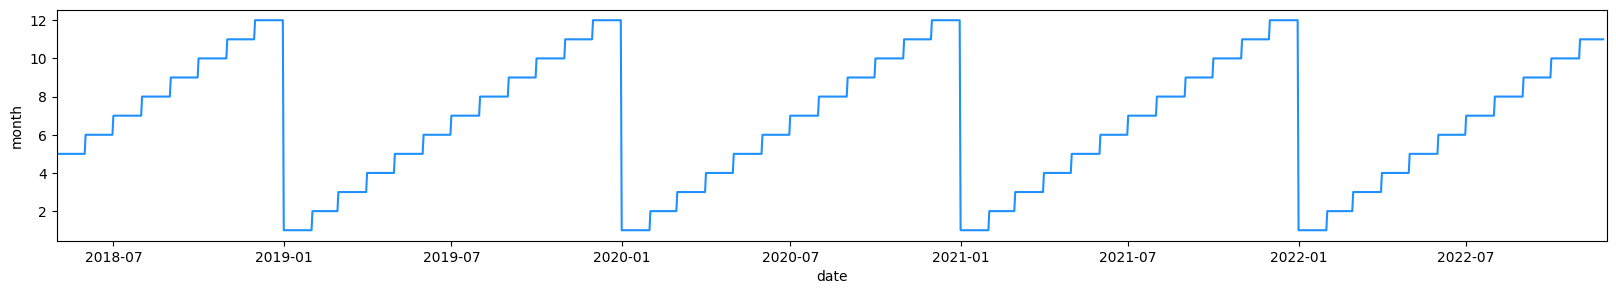

In [24]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')
ax.set_xlim([date(2018, 5, 1), date(2022, 11, 30)])
plt.show()

Lets encode this cyclical feature:

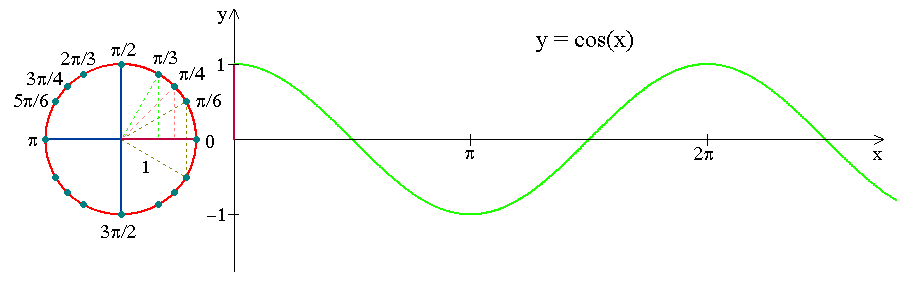

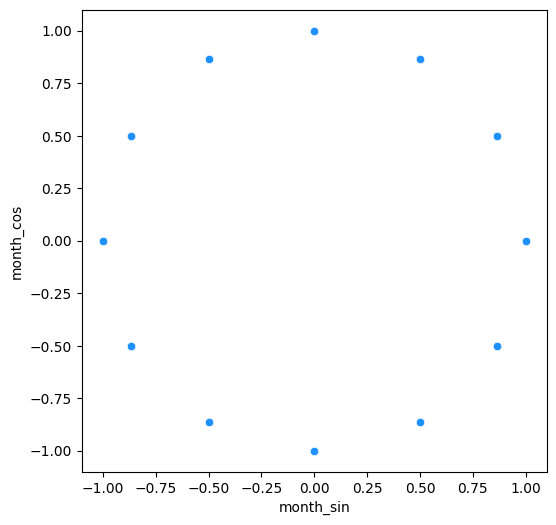

In [25]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

<a id='3.2'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.2 TimeSeries Decomposition</p>

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:

* **Level**: The average value in the series.
* **Trend**: The increasing or decreasing value in the series.
* **Seasonality**: The repeating short-term cycle in the series.
* **Noise**: The random variation in the series.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:
* **Additive**: $y(t) = Level + Trend + Seasonality + Noise$
* **Multiplicative**: $y(t) = Level * Trend * Seasonality * Noise$

In this case we are going to use function seasonal_decompose() from the [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) library.

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'sales', 'member', 'margin', 
    'quantity', 'cogs'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

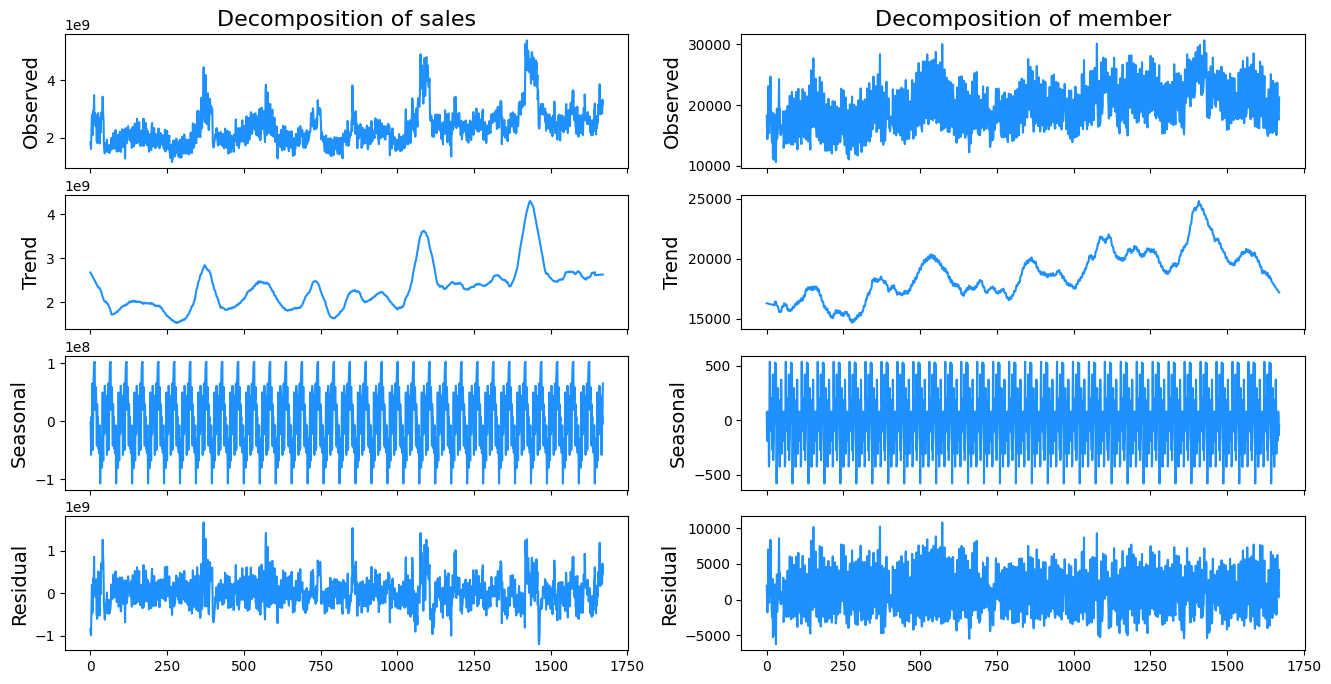

In [27]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['sales', 'member']):
    
    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

<a id='3.3'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">3.3 Lag</p>


We want to calculate each variable with a `shift()` (lag) to compare the correlationwith the other variables.

You can see [documentation of shift function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) for more information.

In [28]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">4. Exploratory Data Analysis 📊</p>

Now, we are going to plot the data and try to extract some knowledge.

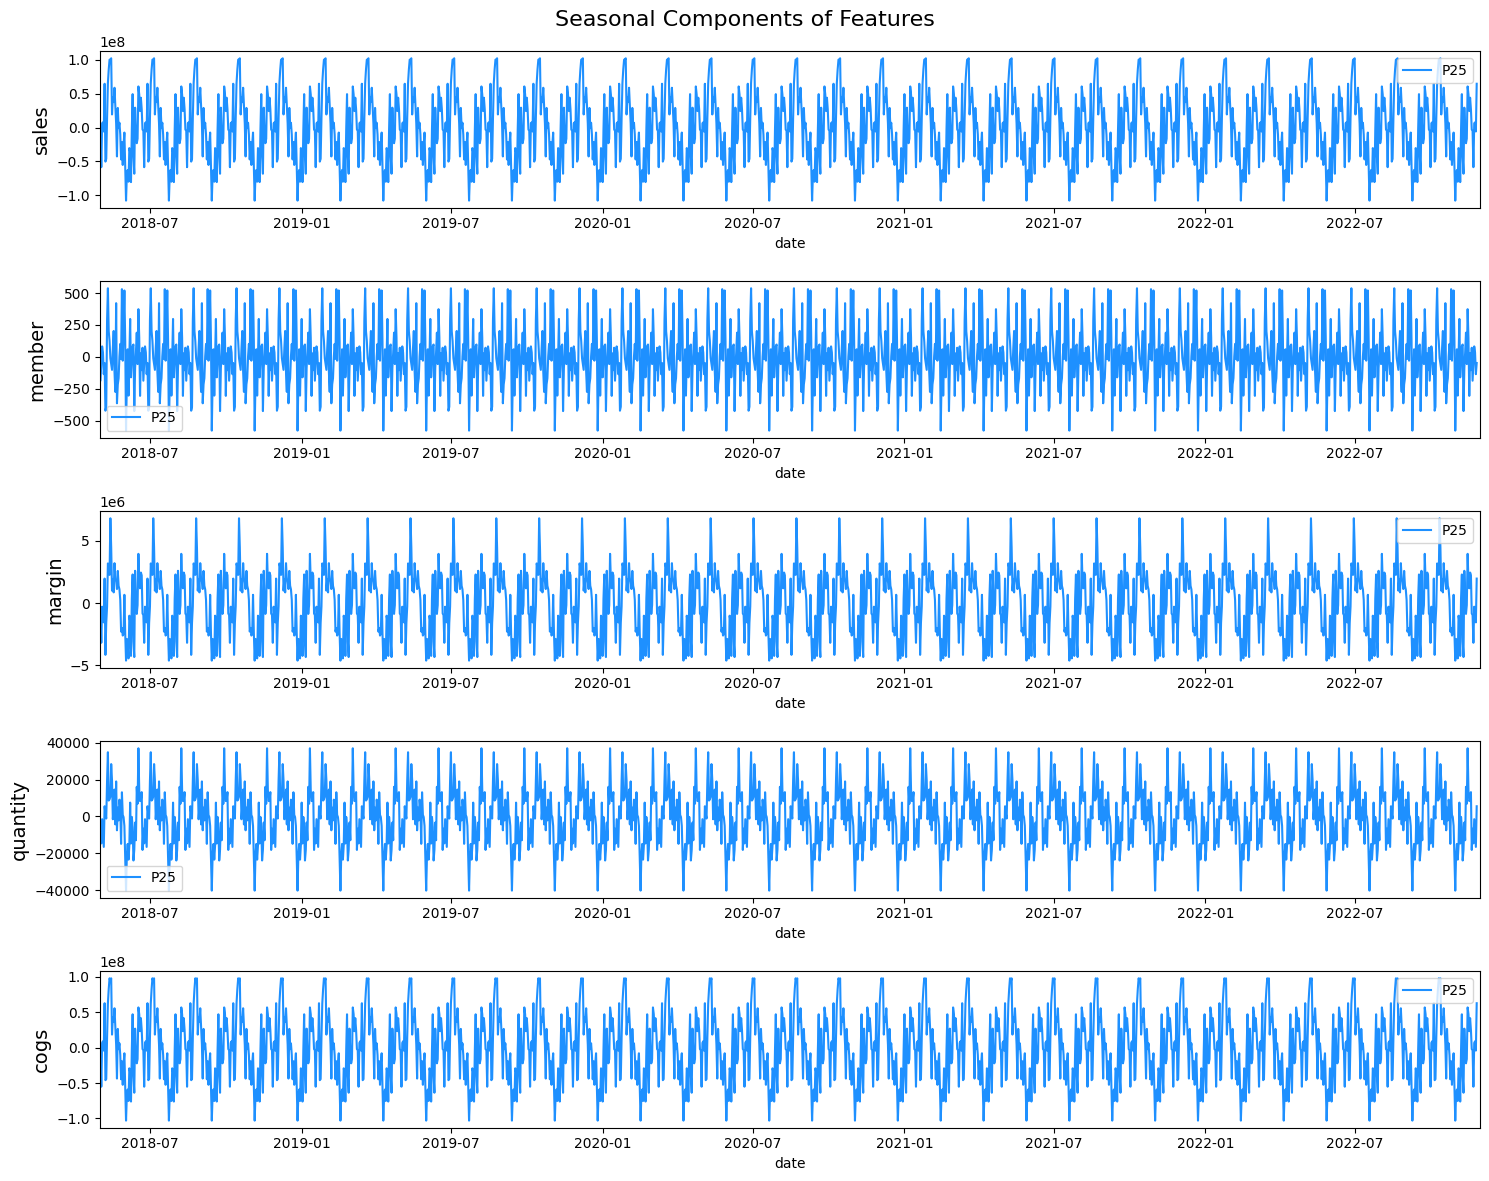

In [29]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2018, 5, 1), date(2022, 11, 30)])
    
plt.tight_layout()
plt.show()

As we can see:
* **Sales**: reaches its maximum around April and its minimum around May

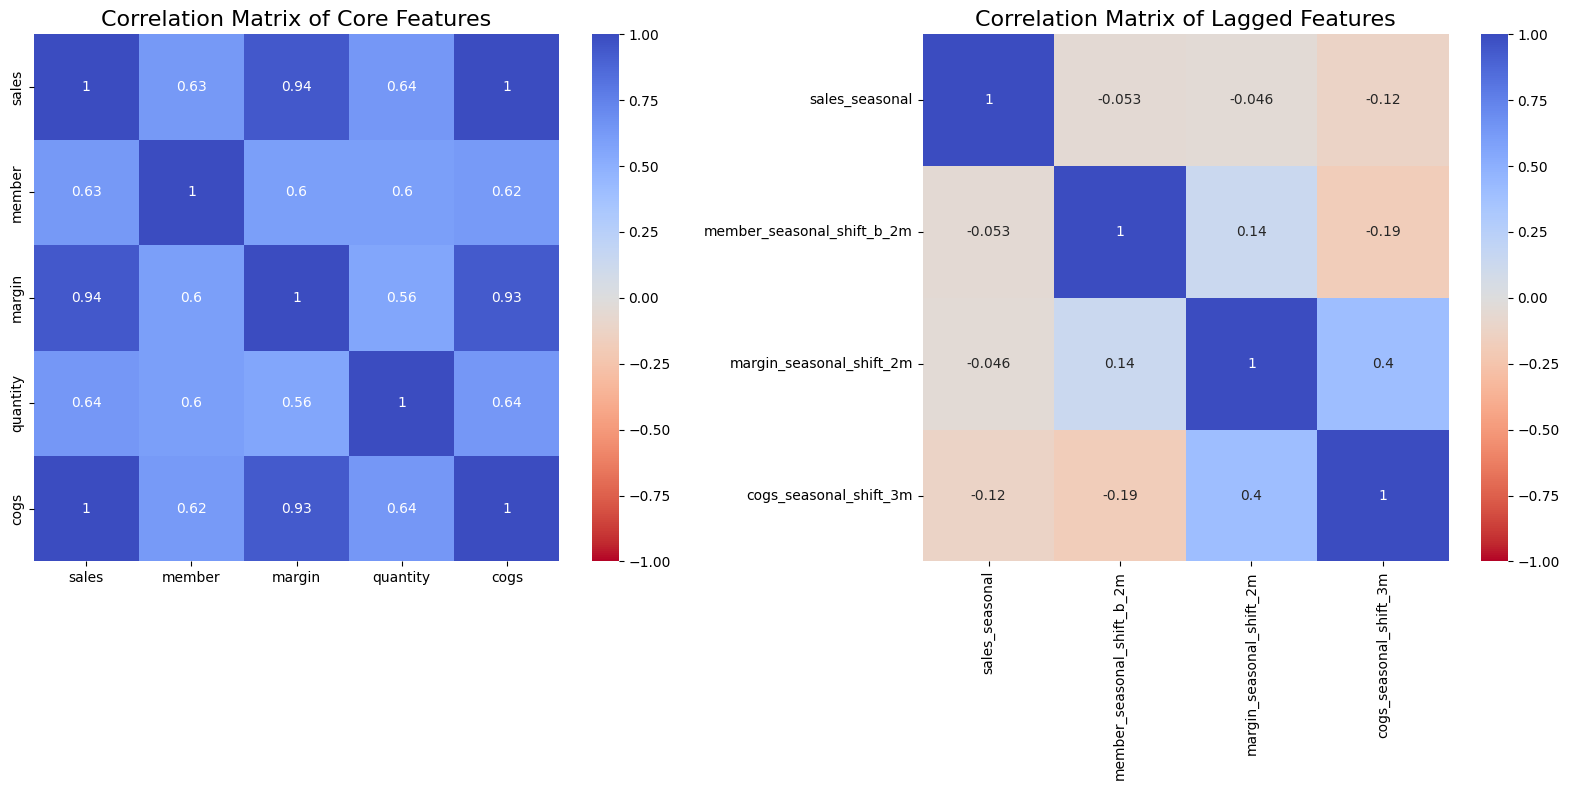

In [30]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'sales_seasonal',         
    'member_seasonal_shift_b_2m',
    'margin_seasonal_shift_2m', 
    'cogs_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

<a id='4.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">4.1 Autocorrelation Analysis</p>

ACF and PACF plots: After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. Of course, with software like Statgraphics, you could just try some different combinations of terms and see what works best. But there is a more systematic way to do this. By looking at the **autocorrelation function (ACF)** and **partial autocorrelation (PACF)** plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

* **Autocorrelation Function (ACF)**: P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter
* **Partial Autocorrelation Function (PACF)**: D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

Autocorrelation plots help in detecting seasonality.

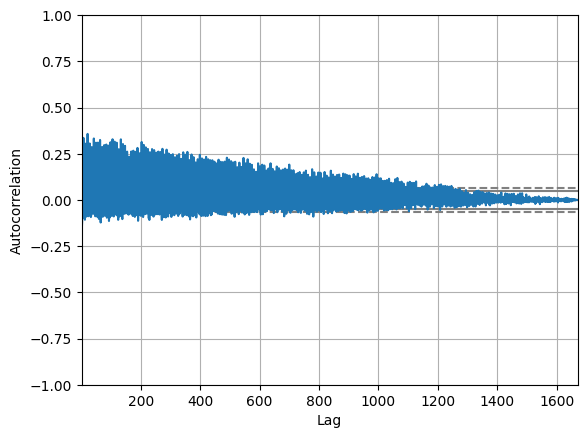

In [31]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['sales_diff_1'])
plt.show()

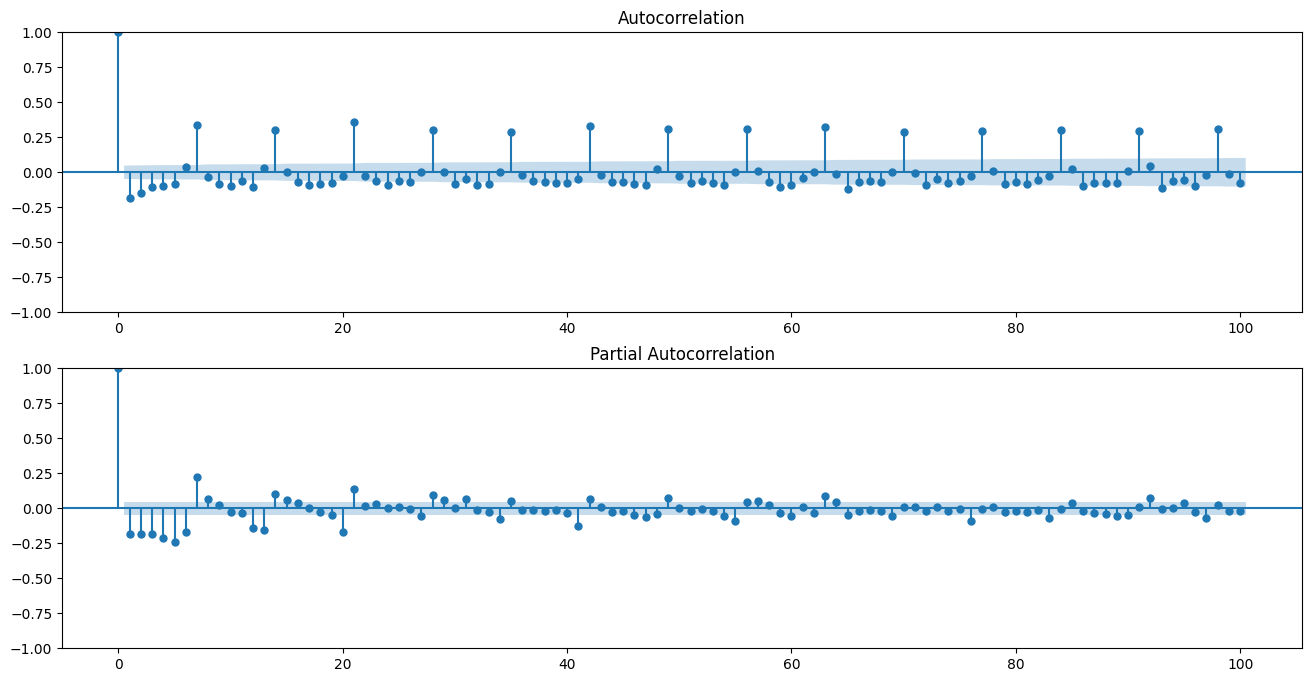

In [32]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['sales_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['sales_diff_1'], lags=100, ax=ax[1])

plt.show()

<a id='5'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">5. Modeling 🧩</p>

Time series can be either univariate or multivariate:

* **Univariate** time series only has a single time-dependent variable.
* **Multivariate** time series have a multiple time-dependent variable.

But, first of all we are going to see how does cross-validation technic works in TimeSeries Analysis. 

In [33]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['sales']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

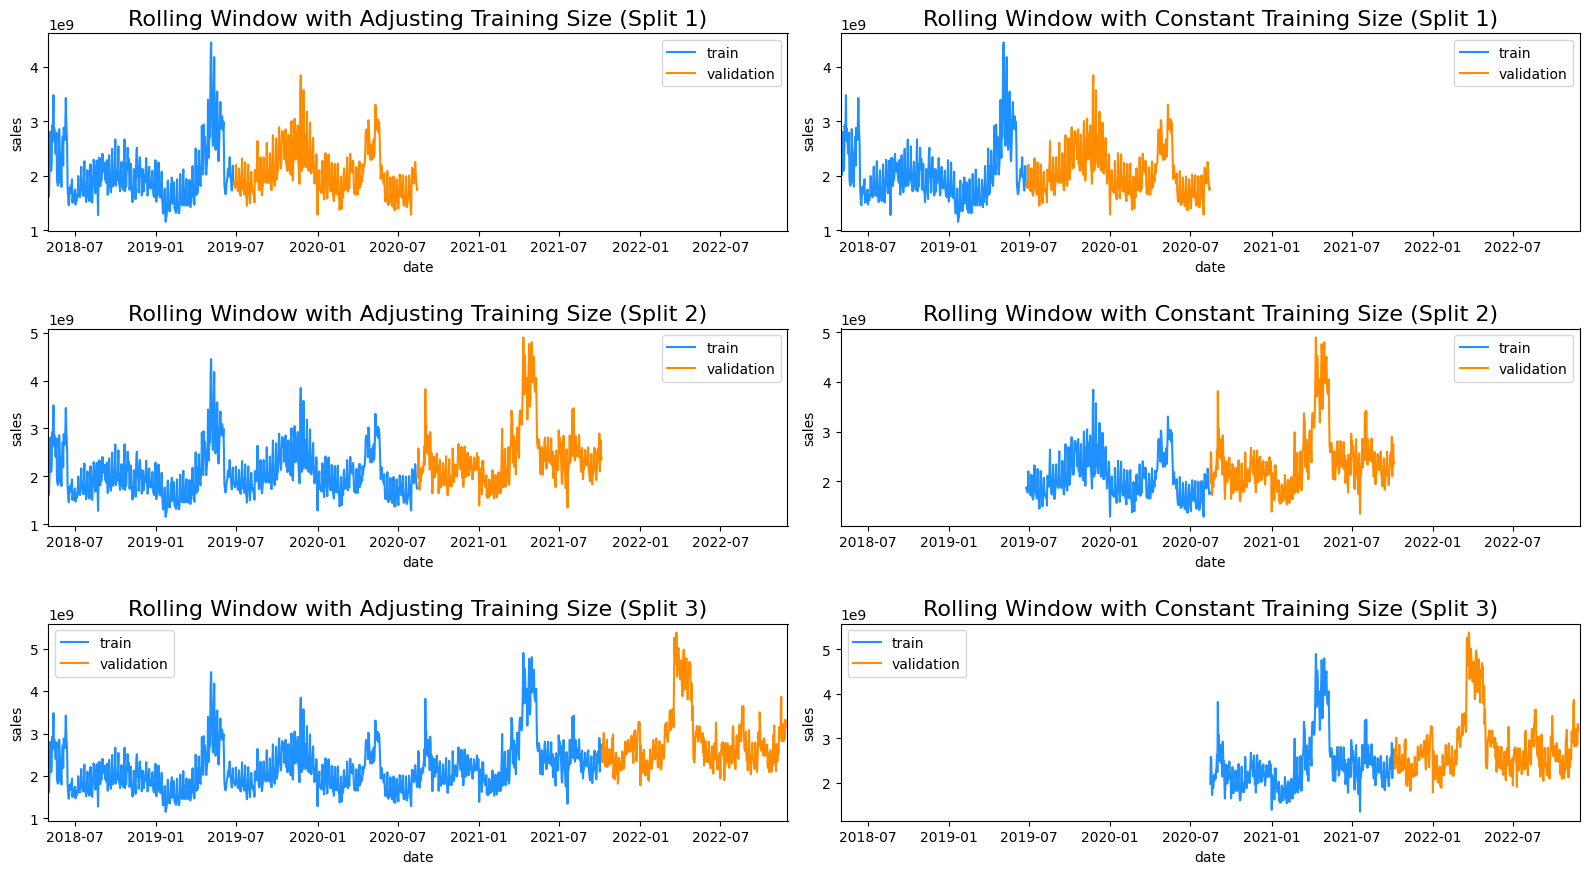

In [34]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2018, 5, 1), date(2022, 11, 30)])
    ax[i, 1].set_xlim([date(2018, 5, 1), date(2022, 11, 30)])
    
plt.tight_layout()
plt.show()

The idea with this plot is to understand which train and test set are we using to fit the model in each iteration. 

<a id='5.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center">5.1 Models for Multivariate Time Series</p>

Finnally, we are going to analize multivariate TimeSeries forecasting.

**Multivariate time series:** Multiple variables are varying over time. For example, a tri-axial accelerometer. There are three accelerations, one for each axis (x,y,z) and they vary simultaneously over time.

In [35]:
feature_columns = [
    'member',
    'margin',
    'quantity',
    'cogs',
]
target_column = ['sales']

train_size = int(0.75 * len(df))

multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:1584, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:1584, 1])
x_test, y_test = pd.DataFrame(multivariate_df.iloc[1584:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[1584:, 1])
train.head()

ds             y   member       margin      quantity          cogs
0 2018-05-01  1.842634e+09  18295.0  76273242.59  1.130964e+06  1.766361e+09
1 2018-05-02  1.735156e+09  15927.0  71270127.97  1.130964e+06  1.663886e+09
2 2018-05-03  1.614953e+09  14420.0  63691143.21  1.130964e+06  1.551262e+09
3 2018-05-04  2.024222e+09  16053.0  81199681.84  1.130964e+06  1.943022e+09
4 2018-05-05  2.354283e+09  18356.0  94021382.58  1.130964e+06  2.260261e+09

In [36]:
train_size

1253

In [37]:
print(len(train), len(x_valid), len(x_test))

1253 331 87


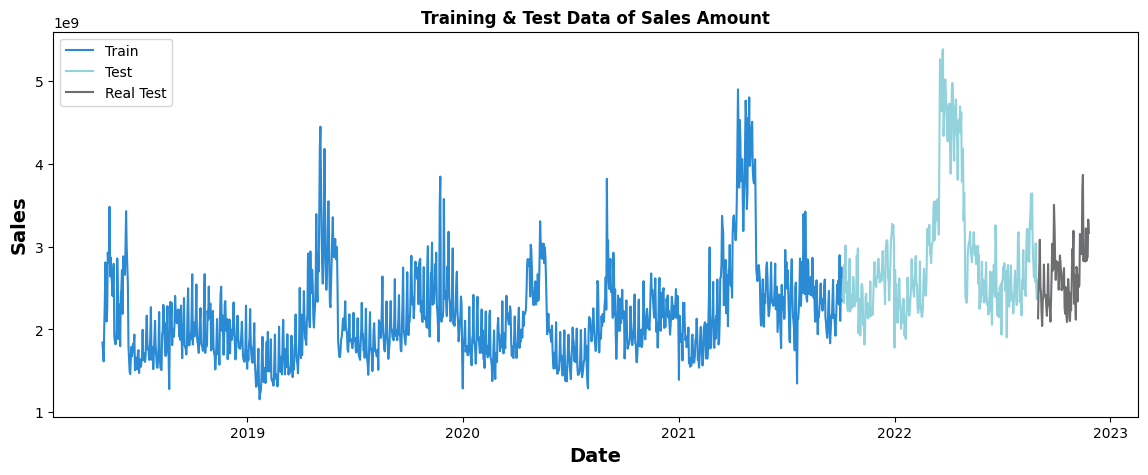

In [38]:
f, ax = plt.subplots(figsize=(14,5))
sns.lineplot(x=x_train['ds'], y=y_train['y'], color='#2A8AD4', label='Train', ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], color='#91D2DC', label='Test', ax=ax)
sns.lineplot(x=x_test['ds'], y=y_test['y'], color='#6D6E70', label='Real Test', ax=ax)

ax.set_xlabel(xlabel='Date', fontsize=14, fontweight='bold')
ax.set_ylabel(ylabel='Sales', fontsize=14, fontweight='bold')
plt.title('Training & Test Data of Sales Amount', fontweight='bold')
plt.legend(loc='upper left')
plt.show()

In [39]:
x_train

ds   member        margin      quantity          cogs
0    2018-05-01  18295.0  7.627324e+07  1.130964e+06  1.766361e+09
1    2018-05-02  15927.0  7.127013e+07  1.130964e+06  1.663886e+09
2    2018-05-03  14420.0  6.369114e+07  1.130964e+06  1.551262e+09
3    2018-05-04  16053.0  8.119968e+07  1.130964e+06  1.943022e+09
4    2018-05-05  18356.0  9.402138e+07  1.130964e+06  2.260261e+09
...         ...      ...           ...           ...           ...
1248 2021-09-30  18738.0  1.285051e+08  1.216472e+06  2.767051e+09
1249 2021-10-01  19554.0  1.095802e+08  1.082218e+06  1.994778e+09
1250 2021-10-02  24020.0  1.296594e+08  1.276334e+06  2.324068e+09
1251 2021-10-03  28126.0  1.347050e+08  1.516278e+06  2.615245e+09
1252 2021-10-04  21602.0  1.100036e+08  1.243674e+06  2.236370e+09

[1253 rows x 5 columns]

In [40]:
x_valid

ds   member        margin   quantity          cogs
1253 2021-10-05  20645.0  1.192566e+08  1213935.0  2.262451e+09
1254 2021-10-06  19952.0  1.240002e+08  1282225.0  2.479281e+09
1255 2021-10-07  19055.0  1.050852e+08  1208185.0  2.215499e+09
1256 2021-10-08  20557.0  1.524635e+08  1327386.0  2.625176e+09
1257 2021-10-09  23480.0  1.250259e+08  1397375.0  2.595281e+09
...         ...      ...           ...        ...           ...
1579 2022-08-27  21378.0  1.125280e+08  1242146.0  2.464046e+09
1580 2022-08-28  26710.0  1.313594e+08  1501938.0  2.908465e+09
1581 2022-08-29  19566.0  1.212247e+08  1150508.0  2.396980e+09
1582 2022-08-30  18279.0  1.081499e+08  1125779.0  2.257429e+09
1583 2022-08-31  18680.0  1.097105e+08  1157256.0  2.488764e+09

[331 rows x 5 columns]

In [41]:
x_test

ds   member        margin   quantity          cogs
1584 2022-09-01  18103.0  1.006103e+08  1041019.0  2.034499e+09
1585 2022-09-02  20129.0  1.111629e+08  1131367.0  2.395900e+09
1586 2022-09-03  24289.0  1.212648e+08  1320305.0  2.602521e+09
1587 2022-09-04  28525.0  1.322125e+08  1485699.0  2.950042e+09
1588 2022-09-05  20781.0  1.127665e+08  1232959.0  2.403171e+09
...         ...      ...           ...        ...           ...
1666 2022-11-22  18563.0  1.258999e+08  1188802.0  2.703270e+09
1667 2022-11-23  18010.0  1.421490e+08  1172493.0  2.714777e+09
1668 2022-11-24  17602.0  1.400350e+08  1163680.0  2.737079e+09
1669 2022-11-25  18791.0  1.610702e+08  1311155.0  3.164469e+09
1670 2022-11-26  21289.0  1.533698e+08  1343876.0  3.011264e+09

[87 rows x 5 columns]

<a id='5.1.1'></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">5.1.1 Multivariate Prophet</p>

The first model (which also can handle multivariate problems) we are going to try is Facebook Prophet.

Prophet, or “Facebook Prophet,” is an open-source library for univariate (one variable) time series forecasting developed by Facebook.

Prophet implements what they refer to as an additive time series forecasting model, and the implementation supports trends, seasonality, and holidays.

### Prepare Holiday and Ramadhan Dates Dataframe

In [42]:
#Prepare holiday and ramadhan dataframe
df_holiday = pd.read_csv("indo-public-holiday.csv")
df_holiday.columns = ['ds','holiday','desc','group']
df_ramadhan = pd.read_csv("ramadhan.csv")
df_ramadhan.columns = ['ds','holiday']

df_holiday['holiday'].mask(df_holiday['holiday'] == 'Public Holiday', 'public', inplace=True)
df_holiday['holiday'].mask(df_holiday['holiday'] == 'Joint Holiday', 'joint', inplace=True)
df_holiday = df_holiday.drop(['desc','group'],axis=1)
df_ramadhan['holiday'].mask(df_ramadhan['holiday'] == 'Ramadhan', 'ramadhan', inplace=True)

df_holiday['ds'] = pd.to_datetime(df_holiday['ds'], format = '%d/%m/%Y')
df_holiday['ds'] = pd.to_datetime(df_holiday['ds'].dt.strftime('%Y-%m-%d'))
df_ramadhan['ds'] = pd.to_datetime(df_ramadhan['ds'], format = '%d/%m/%Y')
df_ramadhan['ds'] = pd.to_datetime(df_ramadhan['ds'].dt.strftime('%Y-%m-%d'))

df_holiday['lower_window'] = -5
df_holiday['upper_window'] = 5
df_ramadhan['lower_window'] = -10
df_ramadhan['upper_window'] = 10

In [43]:
df_libur = pd.merge(df_holiday, df_ramadhan, on=["ds","holiday","lower_window","upper_window"], how="outer")
df_libur

ds   holiday  lower_window  upper_window
0   2018-01-01    public            -5             5
1   2018-02-16    public            -5             5
2   2018-03-17    public            -5             5
3   2018-03-30    public            -5             5
4   2018-04-14    public            -5             5
..         ...       ...           ...           ...
253 2022-04-27  ramadhan           -10            10
254 2022-04-28  ramadhan           -10            10
255 2022-04-29  ramadhan           -10            10
256 2022-04-30  ramadhan           -10            10
257 2022-05-01  ramadhan           -10            10

[258 rows x 4 columns]

In [44]:
df_libur.to_csv("holiday-effect.csv", index=False)

### Hyperparameter Tuning using Parameter Grid

In [45]:
from sklearn.model_selection import ParameterGrid

params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
               'seasonality_prior_scale':[0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
               'holidays_prior_scale':[0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]}

grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 3456


In [46]:
# import math

# from prophet import Prophet
# from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])

# for p in grid:
#     test = pd.DataFrame()
#     print(p)
#     random.seed(0)
#     train_model = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
#                          holidays_prior_scale = p['holidays_prior_scale'],
#                          seasonality_prior_scale = p['seasonality_prior_scale'],
#                          seasonality_mode = p['seasonality_mode'],
#                          weekly_seasonality=True,
#                          daily_seasonality=True,
#                          yearly_seasonality=True,
#                          holidays=df_libur)
#     train_model.add_regressor('member')
#     train_model.add_regressor('margin')  
#     train_model.add_regressor('quantity')
#     train_model.add_regressor('cogs')
#     train_model.fit(train)

#     #train_forecast = train_model.make_future_dataframe(periods=test_size, freq='D',include_history = False)
#     train_forecast = train_model.predict(x_valid)
#     y_pred = train_forecast[['ds','yhat']]
    
#     MAPE = mean_absolute_percentage_error(y_valid, y_pred['yhat'])
#     MAE = mean_absolute_error(y_valid, y_pred['yhat'])
#     MSE = mean_squared_error(y_valid, y_pred['yhat'])
#     RMSE = mean_squared_error(y_valid, y_pred['yhat'], squared=False)
#     print('Mean Absolute Percentage Error (MAPE)------------------------------------',MAPE)
#     print('Root Mean Square Error (RMSE)--------------------------------------------',RMSE)
#     model_parameters = model_parameters.append({'MAPE':MAPE,'MAE':MAE,'RMSE':RMSE,'MSE':MSE,'Parameters':p},ignore_index=True)

In [47]:
# parameters_mape = model_parameters.sort_values(by=['MAPE']).reset_index(drop=True)
# parameters_mape.to_csv("parameters_tuning_list.csv", index=False)
# parameters_mape.head()

In [48]:
# parameters_rmse = model_parameters.sort_values(by=['RMSE']).reset_index(drop=True)
# parameters_rmse['Parameters'][0]

In [49]:
# parameters_mape['Parameters'][0]

In [50]:
import math

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Train the model
model = Prophet(weekly_seasonality=True,
                daily_seasonality=True,
                yearly_seasonality=True,
                seasonality_mode='multiplicative',
                seasonality_prior_scale=7,
                holidays=df_libur,
                holidays_prior_scale=10,
                changepoint_prior_scale=0.01
                )
model.add_regressor('member')
model.add_regressor('margin')  
model.add_regressor('quantity')
model.add_regressor('cogs')
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on train and valid set
y_pred_train = model.predict(x_train)
y_pred_valid = model.predict(x_valid)
y_pred_test = model.predict(x_test)
y_pred = pd.concat([y_pred_train,y_pred_valid,y_pred_test], axis=0).reset_index(drop=True)

# Calculate evaluation metrics for train data
score_mae_train = mean_absolute_error(y_train, y_pred_train['yhat'])
score_mape_train = mean_absolute_percentage_error(y_train, y_pred_train['yhat'])*100
score_rmse_train = mean_squared_error(y_train, y_pred_train['yhat'], squared=False)
score_rmpse_train = np.sqrt(np.mean(np.square(((y_train - y_pred_train['yhat']) / y_train)), axis=0))

# Calculate evaluation metrics for train data
score_mae_valid = mean_absolute_error(y_valid, y_pred_valid['yhat'])
score_mape_valid = mean_absolute_percentage_error(y_valid, y_pred_valid['yhat'])*100
score_rmse_valid = mean_squared_error(y_valid, y_pred_valid['yhat'], squared=False)
score_rmpse_valid = np.sqrt(np.mean(np.square(((y_valid - y_pred_valid['yhat']) / y_valid)), axis=0))

# Calculate evaluation metrics for test data
score_mae_test = mean_absolute_error(y_test, y_pred_test['yhat'])
score_mape_test = mean_absolute_percentage_error(y_test, y_pred_test['yhat'])*100
score_rmse_test = mean_squared_error(y_test, y_pred_test['yhat'], squared=False)
score_rmpse_test = np.sqrt(np.mean(np.square(((y_test - y_pred_test['yhat']) / y_test)), axis=0))

print(Fore.YELLOW + 'MAPE Train: {0:.2f}%'.format(score_mape_train))
print(Fore.GREEN + 'MAE Train: {:,.2f}'.format(score_mae_train))
print(Fore.BLUE + 'RMSE Train: {:,.2f}'.format(score_rmse_train))

print(Fore.YELLOW + 'MAPE Valid: {0:.2f}%'.format(score_mape_valid))
print(Fore.GREEN + 'MAE Valid: {:,.2f}'.format(score_mae_valid))
print(Fore.BLUE + 'RMSE Valid: {:,.2f}'.format(score_rmse_valid))

print(Fore.YELLOW + 'MAPE Test: {0:.2f}%'.format(score_mape_test))
print(Fore.GREEN + 'MAE Test: {:,.2f}'.format(score_mae_test))
print(Fore.BLUE + 'RMSE Test: {:,.2f}'.format(score_rmse_test))

13:52:41 - cmdstanpy - INFO - Chain [1] start processing
13:52:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE Train: 0.00%
MAE Train: 28,410.53
RMSE Train: 43,273.25
MAPE Valid: 0.00%
MAE Valid: 55,849.38
RMSE Valid: 78,600.45
MAPE Test: 0.00%
MAE Test: 50,778.21
RMSE Test: 53,656.77


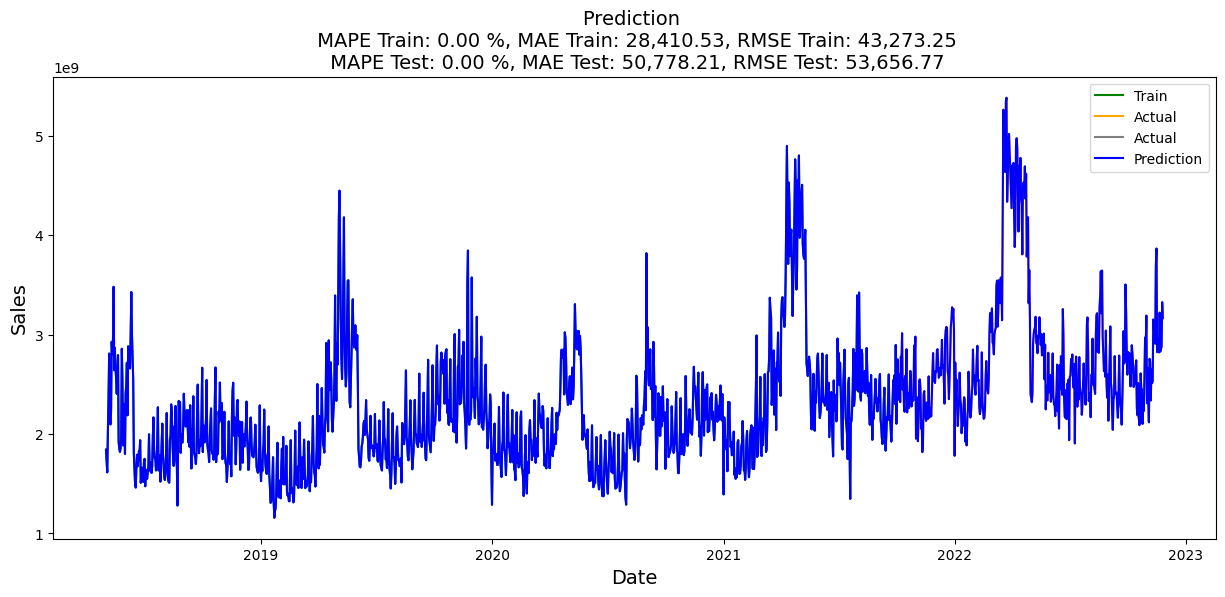

In [51]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

# model.plot(y_pred, ax=ax)
sns.lineplot(x=x_train['ds'], y=y_train['y'], ax=ax, color='green', label='Train') #navajowhite
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Actual') #navajowhite
sns.lineplot(x=x_test['ds'], y=y_test['y'], ax=ax, color='gray', label='Actual') #navajowhite
sns.lineplot(x=y_pred['ds'], y=y_pred['yhat'], ax=ax, color='blue', label='Prediction') #navajowhite

ax.set_title(f'Prediction \n MAPE Train: {score_mape_train:.2f} %, MAE Train: {score_mae_train:,.2f}, RMSE Train: {score_rmse_train:,.2f}\n MAPE Test: {score_mape_test:.2f} %, MAE Test: {score_mae_test:,.2f}, RMSE Test: {score_rmse_test:,.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)

plt.show()

Text(0, 0.5, 'Sales')

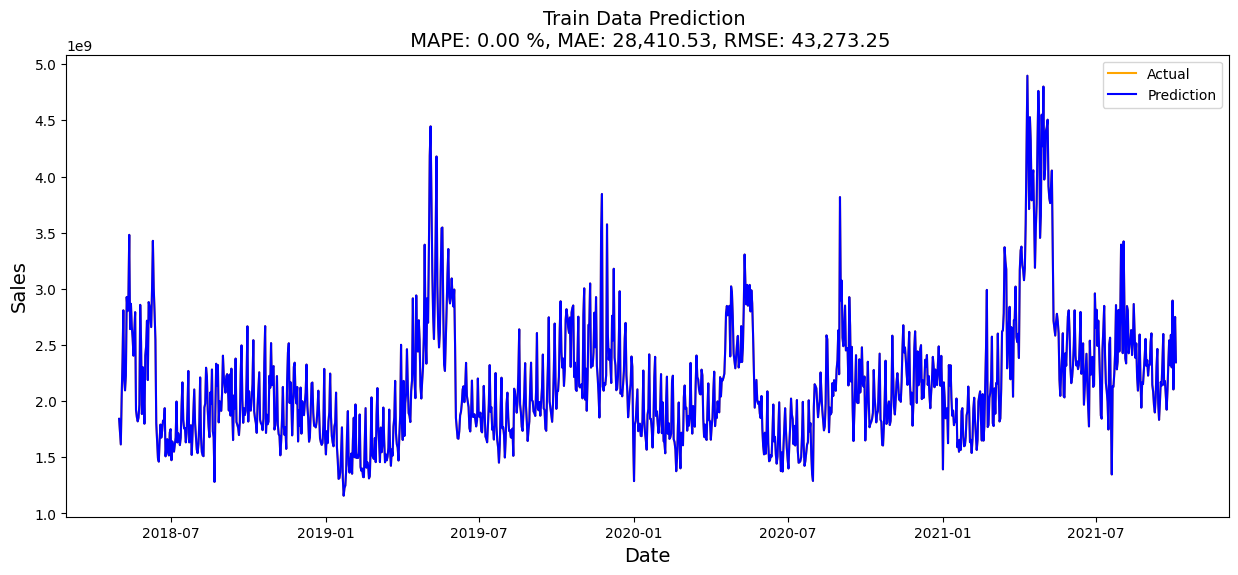

In [52]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

# model.plot(y_pred, ax=ax)
sns.lineplot(x=x_train['ds'], y=y_train['y'], ax=ax, color='orange', label='Actual') #navajowhite
sns.lineplot(x=y_pred_train['ds'], y=y_pred_train['yhat'], ax=ax, color='blue', label='Prediction') #navajowhite

ax.set_title(f'Train Data Prediction \n MAPE: {score_mape_train:.2f} %, MAE: {score_mae_train:,.2f}, RMSE: {score_rmse_train:,.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)

Text(0, 0.5, 'Sales')

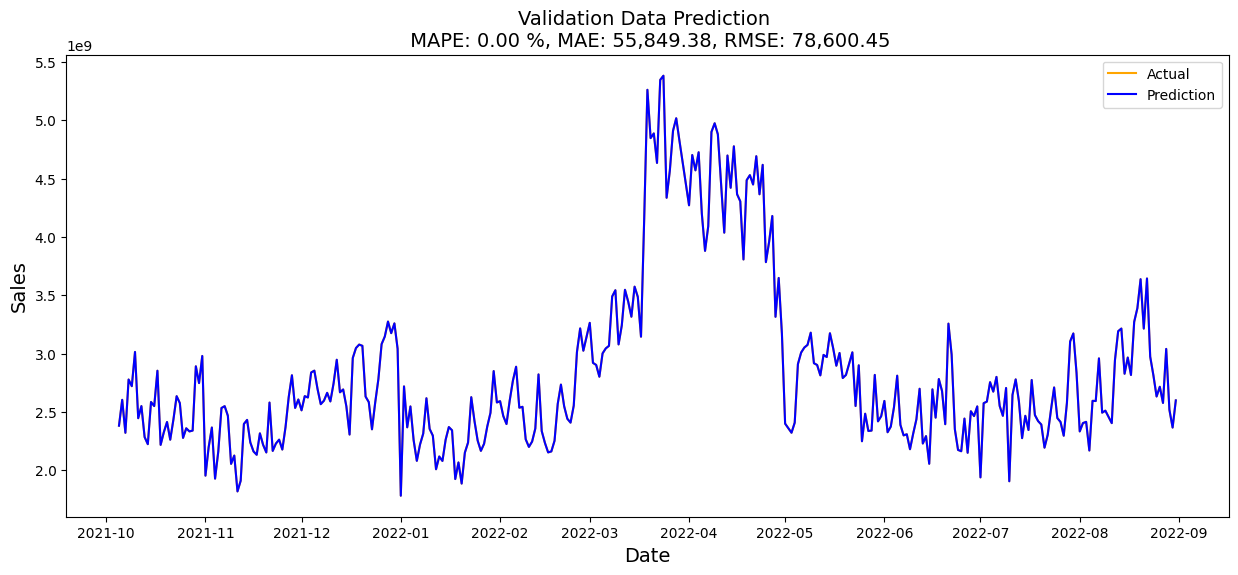

In [53]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

# model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Actual') #navajowhite
sns.lineplot(x=y_pred_valid['ds'], y=y_pred_valid['yhat'], ax=ax, color='blue', label='Prediction') #navajowhite

ax.set_title(f'Validation Data Prediction \n MAPE: {score_mape_valid:.2f} %, MAE: {score_mae_valid:,.2f}, RMSE: {score_rmse_valid:,.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)

In [54]:
prophet_pred = y_pred_valid[['ds','yhat']].copy()
prophet_pred['y'] = y_valid['y'].reset_index(drop=True)
prophet_pred.to_csv("prophet eval.csv", index=False)
prophet_pred


ds          yhat             y
0   2021-10-05  2.381710e+09  2.381707e+09
1   2021-10-06  2.603292e+09  2.603281e+09
2   2021-10-07  2.320601e+09  2.320584e+09
3   2021-10-08  2.777640e+09  2.777640e+09
4   2021-10-09  2.720319e+09  2.720307e+09
..         ...           ...           ...
326 2022-08-27  2.576634e+09  2.576574e+09
327 2022-08-28  3.039896e+09  3.039824e+09
328 2022-08-29  2.518255e+09  2.518204e+09
329 2022-08-30  2.365632e+09  2.365579e+09
330 2022-08-31  2.598542e+09  2.598475e+09

[331 rows x 3 columns]

Text(0, 0.5, 'Sales')

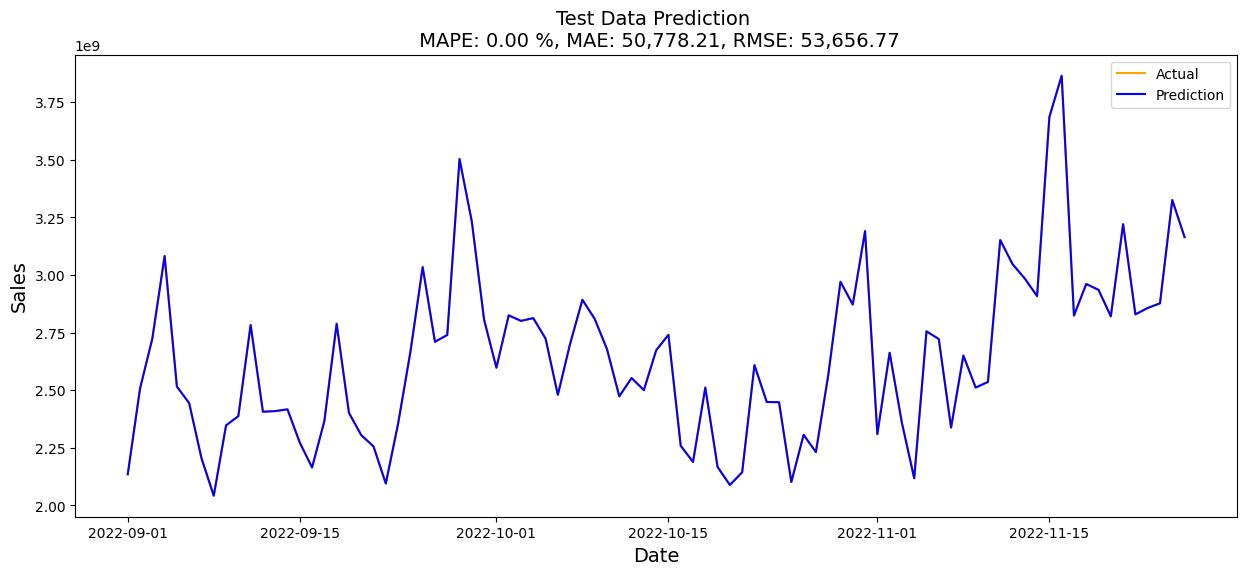

In [55]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

# model.plot(y_pred, ax=ax)
sns.lineplot(x=x_test['ds'], y=y_test['y'], ax=ax, color='orange', label='Actual') #navajowhite
sns.lineplot(x=y_pred_test['ds'], y=y_pred_test['yhat'], ax=ax, color='blue', label='Prediction') #navajowhite

ax.set_title(f'Test Data Prediction \n MAPE: {score_mape_test:.2f} %, MAE: {score_mae_test:,.2f}, RMSE: {score_rmse_test:,.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)

In [56]:
from prophet.utilities import regressor_coefficients

regressor_coefficients(model)

regressor  regressor_mode        center    coef_lower          coef  \
0    member  multiplicative  1.806322e+04 -1.095110e-09 -1.095110e-09   
1    margin  multiplicative  9.763349e+07  6.423723e-10  6.423723e-10   
2  quantity  multiplicative  1.090406e+06 -3.580834e-12 -3.580834e-12   
3      cogs  multiplicative  2.056899e+09  6.427881e-10  6.427881e-10   

     coef_upper  
0 -1.095110e-09  
1  6.423723e-10  
2 -3.580834e-12  
3  6.427881e-10

In [57]:
actual_period = pd.concat([x_test['ds'], y_test], axis=1, ignore_index=True)
actual_period.columns = ['ds', 'y']
projection_period = y_pred[['ds','yhat','yhat_upper','yhat_lower']].copy()
comparison_period = pd.merge(actual_period, projection_period, how='inner', on='ds')
comparison_period.to_csv("sales-projection-3-months.csv", index=False)
comparison_period

ds             y          yhat    yhat_upper    yhat_lower
0  2022-09-01  2.135109e+09  2.135161e+09  2.136716e+09  2.133456e+09
1  2022-09-02  2.507063e+09  2.507125e+09  2.508721e+09  2.505502e+09
2  2022-09-03  2.723785e+09  2.723847e+09  2.725382e+09  2.722105e+09
3  2022-09-04  3.082255e+09  3.082328e+09  3.084042e+09  3.080727e+09
4  2022-09-05  2.515937e+09  2.515993e+09  2.517595e+09  2.514396e+09
..        ...           ...           ...           ...           ...
82 2022-11-22  2.829170e+09  2.829196e+09  2.831121e+09  2.827487e+09
83 2022-11-23  2.856926e+09  2.856946e+09  2.858745e+09  2.855237e+09
84 2022-11-24  2.877114e+09  2.877141e+09  2.878914e+09  2.875282e+09
85 2022-11-25  3.325540e+09  3.325577e+09  3.327373e+09  3.323656e+09
86 2022-11-26  3.164633e+09  3.164663e+09  3.166528e+09  3.162762e+09

[87 rows x 5 columns]

<a id='6'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center">6. References 📝</p>

Here I am going to reference some useful links that I have used to build this notebook
* Special reference for the helpful information and plots - https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting
* ARIMA - https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06
* Auto-ARIMA - https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
* Keras LSTM - https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* Prophet - https://towardsdatascience.com/time-series-prediction-using-prophet-in-python-35d65f626236
* Special reference - https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting/notebook#Models
* Cyclical features - https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
* ADF - https://medium.com/@cmukesh8688/why-is-augmented-dickey-fuller-test-adf-test-so-important-in-time-series-analysis-6fc97c6be2f0
* ACF/PACF - https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8
* LSTM - https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba